<a href="https://colab.research.google.com/github/enricomarchesin/RTSPAllTheThings/blob/master/progetto_gruppo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREMESSA

Un noto capital venture fund vi ha ingaggiato per analizzare il mercato delle app sul Google
Play Store a partire dal dataset di una Kaggle competition e preparare di conseguenza la
strategia degli investimenti nel settore.

Il dataset di Kaggle è disponibile qui: https://www.kaggle.com/lava18/google-play-store-apps

I dati forniti NON sono completi su tutto il Playstore (per politiche di distribuzione dei dati da
parte del fornitore) ma costituiscono una vista importante sui trend del mercato digitale
targato Android e comprendono anche testo non strutturato delle recensione degli utenti.

Purtroppo i dati (anche la parte strutturata) non sono pulitissimi e la semantica del dato non è
descritta in maniera completa.


---



DATASET

Googleplaystore: (1.3 MB): contiene le specifiche delle App sullo store. Esistono 13
feature.

Googleplaystore_user_review: (7.31 MB) le prime 100 recensioni "più rilevanti" per
ciascuna app. Ogni testo / commento della recensione è stato pre-elaborato e attribuito
con 3 nuove funzionalità.


---


SCOPO DEL PROGETTO

Il vostro committente ha la classica percezione che da quel set di dati si possa
estrarre del valore, ma non ha una chiara idea di come trasformare l’informazione
in insights.

A valle di un’analisi esplorativa* dettagliata il vostro obiettivo è per l’appunto
proporre possibili scenari di utilizzo dei dati sia nell’ottica di interpretare i
fenomeni sia in chiave predittiva sugli score di valutazione delle App.

(*) Ti consigliamo di leggere questo post (https://bit.ly/3lSfiWD) per comprendere bene la differenza
tra exploratory analysis e explanatory analysis. *testo in corsivo*


---


DELIVERABLES

1) Una presentazione tecnica (in forma di Jupyter Notebook) che descriva l’exploratory
analysis e le tecniche adottate in chiave predittiva e di gestione del linguaggio naturale.

2) Una presentazione dal taglio business al management dell’azienda (in forma .ppt) mirata
a illustrare in maniera sintetica i primi insights e le possibili strade per sfruttare al meglio le
informazioni che possono derivare da questo dataset.



In [2]:
!pip install PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

pd.set_option('display.max_columns', None)  
%matplotlib inline
# set default image size for all charts
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [ ]:
from notebook import notebookapp
notebook_urls = [server.get('url') for server in notebookapp.list_running_servers()]
print("Notebook URLs:", notebook_urls)
is_notebook_running_locally = 'http://localhost:8888/' in notebook_urls
print("Running in local notebook:", is_notebook_running_locally)

Notebook URLs: ['http://172.28.0.2:9000/']
Running in local notebook: False


In [ ]:
if is_notebook_running_locally:
    # NON-COLAB DATA LOAD
    from p1utils import *

    # gps = load_csv_table("googleplaystore")
    # save_raw("googleplaystore", gps)
    # gps_ur = load_csv_table("googleplaystore_user_reviews")
    # save_raw("googleplaystore_user_reviews", gps_ur)

    gps = load_raw_parquet("googleplaystore")
    gps_ur = load_raw_parquet("googleplaystore_user_reviews")
else:
    # Google COLAB
    downloaded = drive.CreateFile({'id':"1mQfYtTbbcySh7HVWly1F919SHget60dW"})
    downloaded.GetContentFile('googleplaystore.csv') 
    gps_original = pd.read_csv("googleplaystore.csv")
    gps = gps_original.copy() # working copy

    downloaded = drive.CreateFile({'id':"1QQiQdrDWkaEx3B8_oQOwBfhnI1Uy2rcV"})
    downloaded.GetContentFile('googleplaystore_user_reviews.csv')
    gps_ur_original = pd.read_csv('googleplaystore_user_reviews.csv')
    gps_ur = gps_ur_original.copy() # working copy

In [ ]:
gps.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [ ]:
gps_ur.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [ ]:
# review example
gps_ur.iloc[0,1]

'I like eat delicious food. That\'s I\'m cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"'

## DESCRIPTIVE ANALYSIS

# I. **googleplaystore.csv**

Check number of columns, columns types.

In [ ]:
gps.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

### 1. App
* check unique data and frequency - report as a table. I think that we shouldn't have double application, so number the unique values should be the same as number of rows
* Can we do smth else?

In [ ]:
print('rows number: \t\t', gps.shape[0])
print('\'App\' unique values: \t', gps['App'].unique().shape[0])
print('No. of nan: \t\t',gps['App'].isna().sum())
print('\n')

rows number: 		 10841
'App' unique values: 	 9660
No. of nan: 		 0




In [ ]:
# are there duplicate rows?
gps = gps.drop_duplicates()

print('rows number: \t\t', gps.shape[0])
print('\'App\' unique values: \t', gps['App'].unique().shape[0])
print('No. of nan: \t\t',gps['App'].isna().sum())
print('\n')

rows number: 		 10358
'App' unique values: 	 9660
No. of nan: 		 0




In [ ]:
# a few duplicate were removed, but there are still duplicate apps, apparently

# mmm, very strange... 
# let's see which are the not unique values
gps['App'].value_counts()[gps['App'].value_counts() > 1]

ROBLOX                                        9
8 Ball Pool                                   7
Helix Jump                                    6
Bubble Shooter                                6
Zombie Catchers                               6
                                             ..
Weight Watchers Mobile                        2
Overstock – Home Decor, Furniture Shopping    2
Microsoft Edge                                2
Farming Simulator 14                          2
Mint: Budget, Bills, Finance                  2
Name: App, Length: 523, dtype: int64

In [ ]:
# what happens? let's see the first example
gps[gps['App'] == 'ROBLOX']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1653,ROBLOX,GAME,4.5,4447388,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
1701,ROBLOX,GAME,4.5,4447346,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
1748,ROBLOX,GAME,4.5,4448791,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
1841,ROBLOX,GAME,4.5,4449882,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
1870,ROBLOX,GAME,4.5,4449910,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
2016,ROBLOX,FAMILY,4.5,4449910,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
2088,ROBLOX,FAMILY,4.5,4450855,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
2206,ROBLOX,FAMILY,4.5,4450890,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up
4527,ROBLOX,FAMILY,4.5,4443407,67M,"100,000,000+",Free,0,Everyone 10+,Adventure;Action & Adventure,"July 31, 2018",2.347.225742,4.1 and up


In [ ]:
# the rows in this case seem to differ in the number of revisions and "Category":
# maybe they are derived from different snapshots over time.
#
# Idea for removing this kind of "duplicates": 
# - order dataframe by Reviews
# - cycle on rows
# - store 'App' value in a set
# - if 'App' value is already present in the set we will drop the entire row
gps = gps.sort_values(by=['Reviews'], ascending=False)

apps = set()
drop_row = []
for index, row in gps.iterrows():
  if row['App'] not in apps:
    drop_row.append(True)
    apps.add(row['App'])
  else:
    drop_row.append(False)

gps = gps[drop_row]

# now we repeat the original check on App
print('rows number: \t\t', gps.shape[0])
print('\'App\' unique values: \t', gps['App'].unique().shape[0])
print('No. of nan: \t\t',gps['App'].isna().sum())
print('\n')

# and re-order by index on rows
gps = gps.sort_index()

rows number: 		 9660
'App' unique values: 	 9660
No. of nan: 		 0




### 2. Category

* check unique data and frequency - report as a table
* visualize frequency as a histogram or a pie
* Can we do smth else?

In [ ]:
print('No. of nan: ',gps['Category'].isna().sum())
print()
print('Category distribution:\n')
cat_vc = gps['Category'].value_counts()
cat_vc

No. of nan:  0

Category distribution:



FAMILY                 1879
GAME                    942
TOOLS                   828
BUSINESS                420
MEDICAL                 395
PERSONALIZATION         376
PRODUCTIVITY            374
LIFESTYLE               369
FINANCE                 345
SPORTS                  325
COMMUNICATION           315
HEALTH_AND_FITNESS      288
PHOTOGRAPHY             281
NEWS_AND_MAGAZINES      254
SOCIAL                  239
BOOKS_AND_REFERENCE     222
TRAVEL_AND_LOCAL        219
SHOPPING                202
DATING                  171
VIDEO_PLAYERS           164
MAPS_AND_NAVIGATION     131
FOOD_AND_DRINK          112
EDUCATION               106
ENTERTAINMENT            87
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       84
WEATHER                  79
HOUSE_AND_HOME           73
EVENTS                   64
ART_AND_DESIGN           61
PARENTING                60
COMICS                   56
BEAUTY                   53
1.9                       1
Name: Category, dtype: int64

In [ ]:
# 1.9 ??? let me look where is it, i suppose is an error
gps[gps['Category'] == '1.9']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [ ]:
# I was right! Data looks to be shifted. There are also 2 missing values and few reviews => I decide to drop this row
gps = gps.loc[gps['Category'] != '1.9']

In [ ]:
# nicer colors for pie chart
pie_cmap = plt.get_cmap('Spectral')
pie_colors = [pie_cmap(i) for i in np.linspace(0, 1, 8)]

In [ ]:
gps['Category'].unique(), len(gps['Category'].unique())

(array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
        'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
        'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
        'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
        'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
        'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
        'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
        'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
       dtype=object), 33)

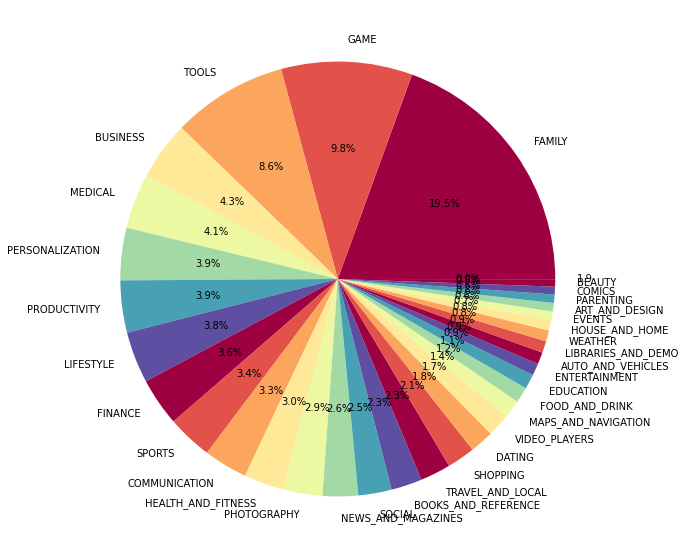

In [ ]:
plt.pie(cat_vc.values, labels = cat_vc.index, autopct='%1.1f%%', colors=pie_colors)
plt.show()

In [ ]:
category_counts = gps['Category'].value_counts()
min_value = category_counts.quantile(.75)
category_df = category_counts.to_frame()
category_df['New Category'] = np.where(category_df['Category'] > min_value, category_df.index, 'Other')
category_with_others = category_df.groupby(['New Category']).sum()

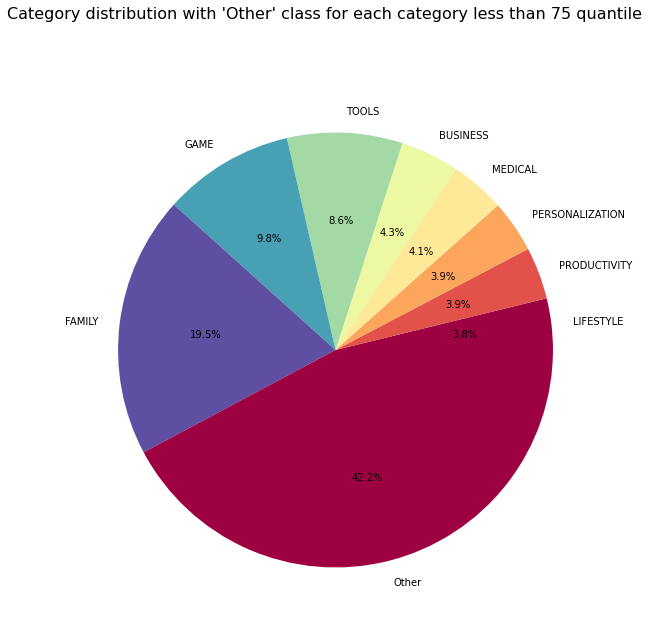

In [ ]:
source_labels = category_with_others.Category.sort_values().index
source_counts = category_with_others.Category.sort_values()

source_pie = plt.pie(source_counts, labels=source_labels, autopct='%1.1f%%', shadow=False, colors=pie_colors)
plt.suptitle('Category distribution with \'Other\' class for each category less than 75 quantile', fontsize=16)
plt.show()

Text(0.5, 0.98, 'Categories distribution')

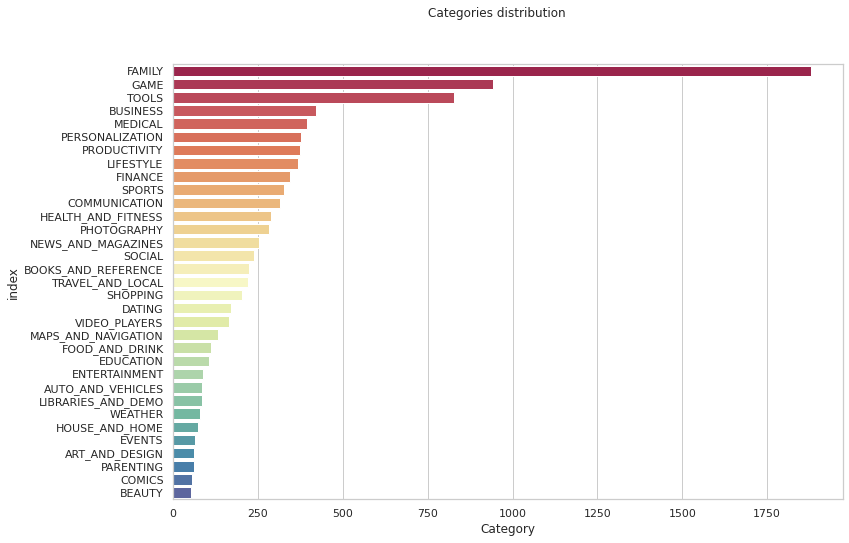

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))
source_data = gps['Category'].value_counts().to_frame().reset_index()
sns.barplot(x='Category',y='index', data=source_data, palette='Spectral')
plt.suptitle('Categories distribution', fontsize=12)

### 3. Rating
* check unique data - report as a table
* check data format and if it should be uniformed, I'm quite sure it should be from 1 to 5 but check it
* visualize frequency as a histogram
* Can we do smth else?

In [ ]:
gps['Rating'].dtype

dtype('float64')

In [ ]:
print('No. of nan: ',gps['Rating'].isna().sum())
print()
print('Rating distribution:\n')
rating_vc = gps['Rating'].value_counts().sort_index()
rating_vc

No. of nan:  1463

Rating distribution:



1.0     16
1.2      1
1.4      3
1.5      3
1.6      4
1.7      8
1.8      8
1.9     11
2.0     12
2.1      8
2.2     14
2.3     20
2.4     19
2.5     20
2.6     24
2.7     23
2.8     40
2.9     45
3.0     81
3.1     69
3.2     63
3.3    100
3.4    126
3.5    156
3.6    167
3.7    224
3.8    286
3.9    359
4.0    513
4.1    621
4.2    811
4.3    897
4.4    897
4.5    849
4.6    683
4.7    438
4.8    221
4.9     85
5.0    271
Name: Rating, dtype: int64

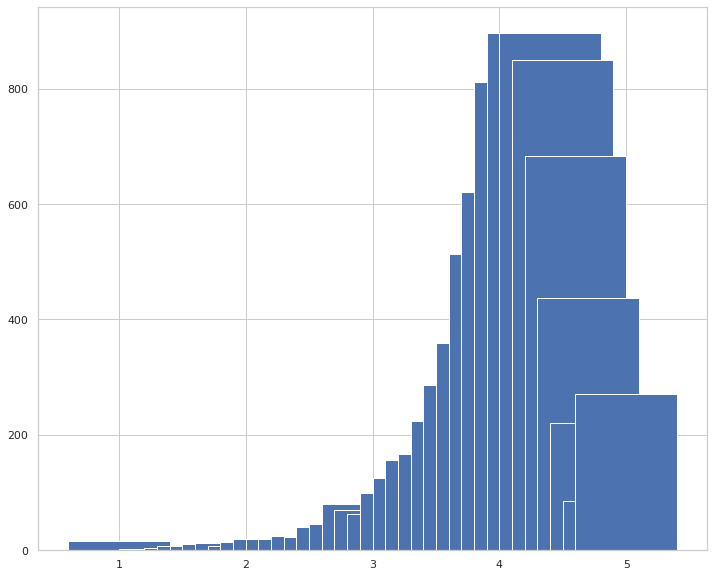

In [ ]:
plt.bar(rating_vc.index, rating_vc.values)
plt.show()

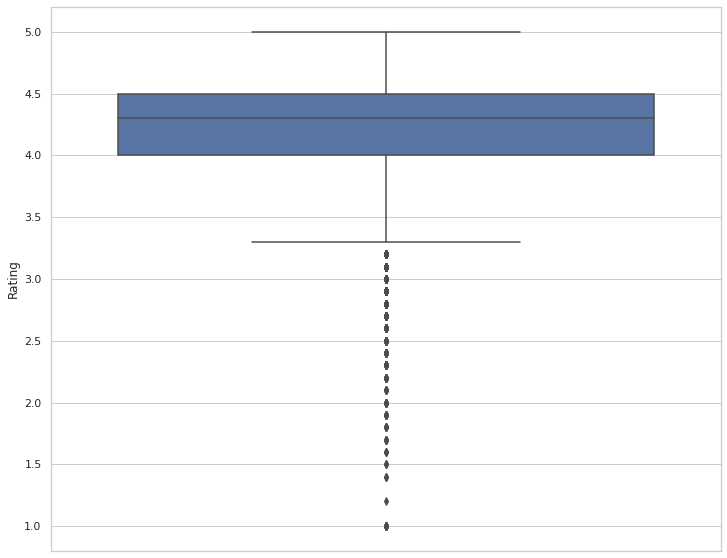

In [ ]:
sns.boxplot(y=gps['Rating'])

In [ ]:
gps['Rating'].mean()

4.173084431429966

### 4. Reviews
*   check unique data - report as a table
*   check data format and if it should be uniformed (seems that 1 record can gives problem, think what to do with it) 
*   visualize frequency as a histogram
*   Can we do smth else?

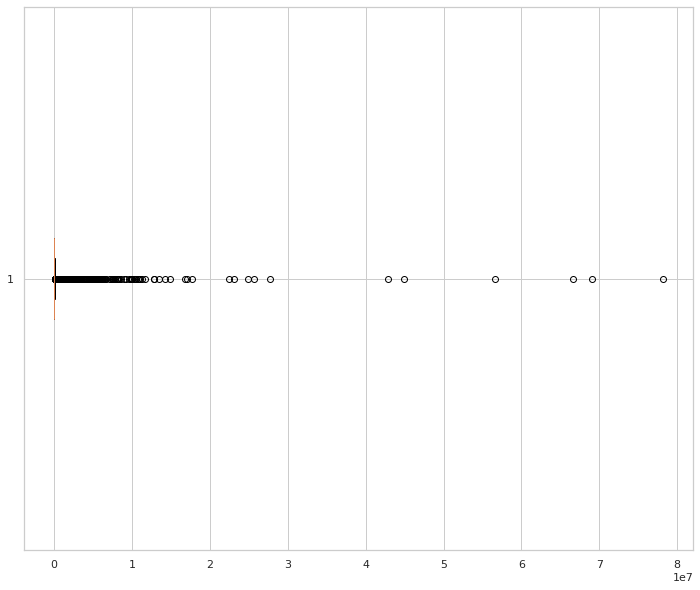

In [ ]:
gps['Reviews'] = gps['Reviews'].astype(int)
plt.boxplot(gps['Reviews'], vert=False)
plt.show()

I quartile:  25.0
I quartile:  29365.5




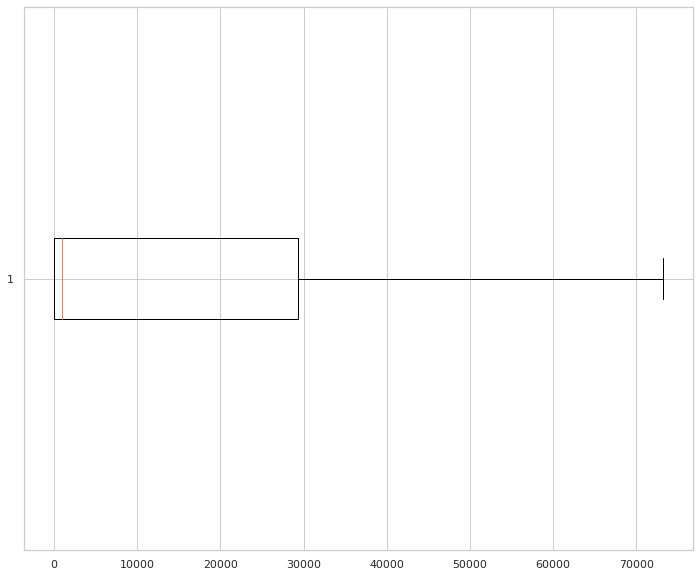

In [ ]:
# let's see the distribution without outliers and print I and III quartile
print("1st quartile: ", gps['Reviews'].quantile(0.25))
print("3rd quartile: ", gps['Reviews'].quantile(0.75))
print("\n")
plt.boxplot(gps['Reviews'], showfliers=False, vert=False)
plt.show()

In [ ]:
# let's we have a look on extreme outliers
gps[gps['Reviews'] > 3e7].sort_values(by=['Reviews'], ascending=False)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2544,Facebook,SOCIAL,4.1,78158306,Varies with device,"1,000,000,000+",Free,0,Teen,Social,"August 3, 2018",Varies with device,Varies with device
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,Varies with device,"1,000,000,000+",Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
2604,Instagram,SOCIAL,4.5,66577446,Varies with device,"1,000,000,000+",Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device
382,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56646578,Varies with device,"1,000,000,000+",Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
1879,Clash of Clans,GAME,4.6,44893888,98M,"100,000,000+",Free,0,Everyone 10+,Strategy,"July 15, 2018",10.322.16,4.1 and up
4005,Clean Master- Space Cleaner & Antivirus,TOOLS,4.7,42916526,Varies with device,"500,000,000+",Free,0,Everyone,Tools,"August 3, 2018",Varies with device,Varies with device


In [ ]:
top_six_by_revies = gps[gps['Reviews'] > 3e7].sort_values(by=['Reviews'], ascending=False)
top_six_by_revies[['App', 'Reviews', 'Installs', 'Type', 'Content Rating']]

,App,Reviews,Installs,Type,Content Rating
2544,Facebook,78158306,"1,000,000,000+",Free,Teen
336,WhatsApp Messenger,69119316,"1,000,000,000+",Free,Everyone
2604,Instagram,66577446,"1,000,000,000+",Free,Teen
382,Messenger – Text and Video Chat for Free,56646578,"1,000,000,000+",Free,Everyone
1879,Clash of Clans,44893888,"100,000,000+",Free,Everyone 10+
4005,Clean Master- Space Cleaner & Antivirus,42916526,"500,000,000+",Free,Everyone


Text(0.5, 0.98, 'More used applications')

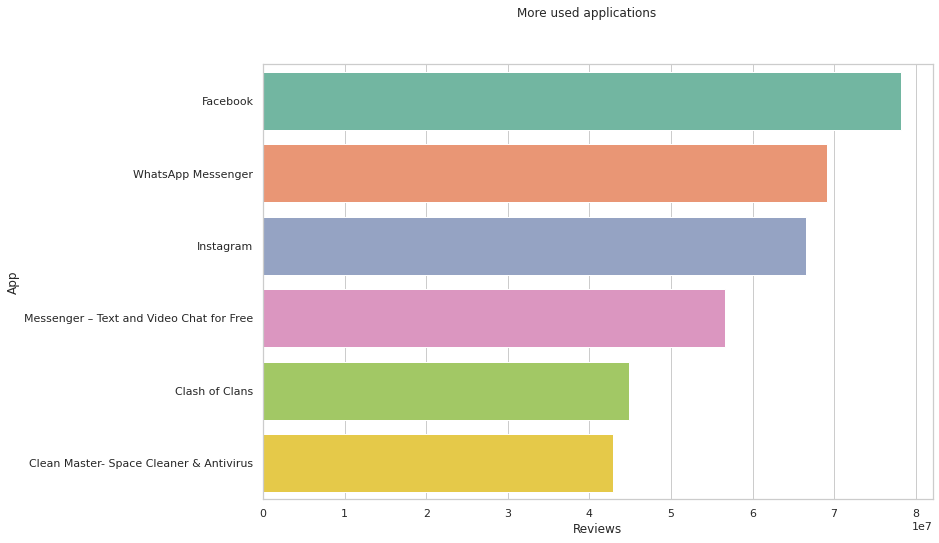

In [ ]:
plt.figure(figsize=(12,8))
source_data = top_six_by_revies
sns.barplot(x='Reviews',y='App', data=source_data, palette='Set2')
plt.suptitle('More used applications', fontsize=12)

### 5. Size

*   check unique data - report as a table
*   format data to the same size and make it uniform (trasform kilo and mega to number value, string "Varies with device" replace with null (?))
* Do we have outliers?
*   visualize frequency as a histogram
*   Can we do smth else?






In [ ]:
gps['Size'].unique()

array(['19M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M', '28M',
       '12M', '20M', '21M', '37M', '2.7M', '5.5M', '17M', '39M', '31M',
       '14M', '4.2M', '23M', '6.0M', '6.1M', '4.6M', '9.2M', '5.2M',
       '11M', 'Varies with device', '9.4M', '15M', '10M', '1.2M', '24M',
       '26M', '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k', '3.6M',
       '5.7M', '8.6M', '2.4M', '27M', '2.5M', '7.0M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '3.7M', '22M', '7.4M', '6.4M', '3.2M', '8.2M', '9.9M',
       '4.9M', '9.5M', '5.0M', '5.9M', '13M', '73M', '6.8M', '3.5M',
       '4.0M', '2.3M', '7.2M', '2.1M', '42M', '7.3M', '9.1M', '55M',
       '23k', '6.5M', '1.5M', '7.5M', '51M', '41M', '48M', '8.5M', '46M',
       '8.3M', '4.3M', '4.7M', '3.3M', '40M', '7.8M', '8.8M', '6.6M',
       '5.1M', '61M', '66M', '8.4M', '118k', '44M', '695k', '1.6M',
       '6.2M

In [ ]:
# I decide to convert any size in the corresponding MB value and to replace 'Varies with device' with a special value: 0
gps['Size'] = gps.apply(lambda row: '0' if row['Size'] == 'Varies with device' else row['Size'], axis=1)
gps['Size'] = gps.apply(lambda row: re.sub(r'M','e3', row['Size']), axis=1)
gps['Size'] = gps.apply(lambda row: re.sub(r'k','', row['Size']), axis=1)
gps['Size'] = gps['Size'].astype(float)
gps['Size'] = gps.apply(lambda row: row['Size']/1000, axis=1)
gps['Size'].unique()

array([1.90e+01, 8.70e+00, 2.50e+01, 2.80e+00, 5.60e+00, 2.90e+01,
       3.30e+01, 3.10e+00, 2.80e+01, 1.20e+01, 2.00e+01, 2.10e+01,
       3.70e+01, 2.70e+00, 5.50e+00, 1.70e+01, 3.90e+01, 3.10e+01,
       1.40e+01, 4.20e+00, 2.30e+01, 6.00e+00, 6.10e+00, 4.60e+00,
       9.20e+00, 5.20e+00, 1.10e+01, 0.00e+00, 9.40e+00, 1.50e+01,
       1.00e+01, 1.20e+00, 2.40e+01, 2.60e+01, 8.00e+00, 7.90e+00,
       5.60e+01, 5.70e+01, 3.50e+01, 5.40e+01, 2.01e-01, 3.60e+00,
       5.70e+00, 8.60e+00, 2.40e+00, 2.70e+01, 2.50e+00, 7.00e+00,
       1.60e+01, 3.40e+00, 8.90e+00, 3.90e+00, 2.90e+00, 3.80e+01,
       3.20e+01, 5.40e+00, 1.80e+01, 1.10e+00, 2.20e+00, 4.50e+00,
       9.80e+00, 5.20e+01, 9.00e+00, 6.70e+00, 3.00e+01, 2.60e+00,
       7.10e+00, 3.70e+00, 2.20e+01, 7.40e+00, 6.40e+00, 3.20e+00,
       8.20e+00, 9.90e+00, 4.90e+00, 9.50e+00, 5.00e+00, 5.90e+00,
       1.30e+01, 7.30e+01, 6.80e+00, 3.50e+00, 4.00e+00, 2.30e+00,
       7.20e+00, 2.10e+00, 4.20e+01, 7.30e+00, 9.10e+00, 5.50e

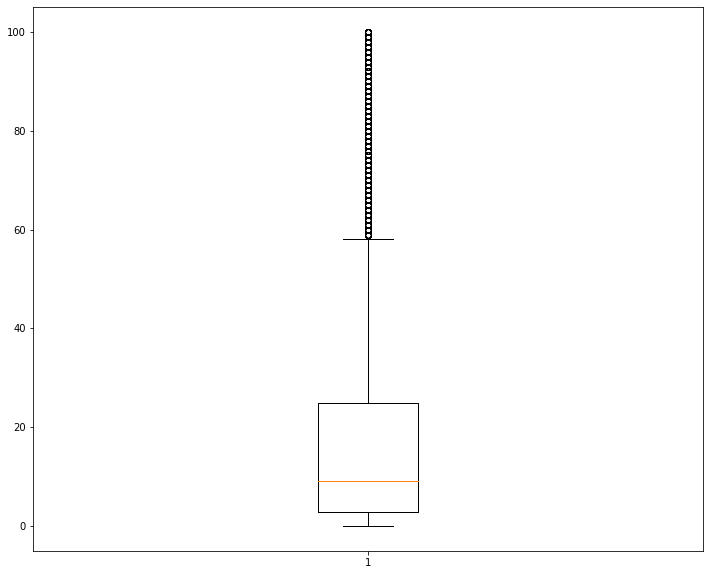

In [ ]:
plt.boxplot(gps['Size'])
plt.show()

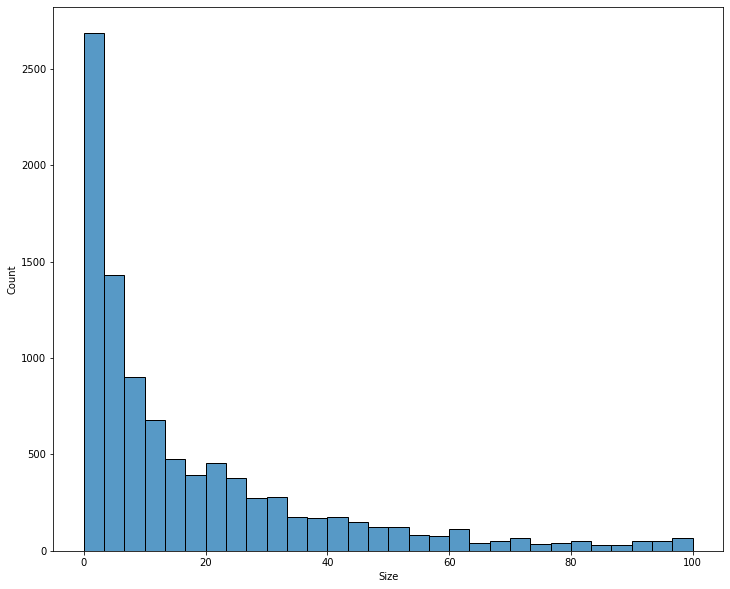

In [ ]:
sns.histplot(data=gps, x="Size", bins=30)

### 6. Installs
*   check unique data - report as a table
*   format data to the same size and make it uniform (now there are strings with '+', and Free -> delete '+', change Free to 0)
* Do we have outliers?
*   visualize frequency as a histogram
*   Can we do smth else?
    * _compare with external data on number of devices to extract app market share of most installed apps?_
    * _max number of install per category?_

In [ ]:
gps['Installs'].unique()

array(['10,000+', '5,000,000+', '50,000,000+', '100,000+', '50,000+',
       '1,000,000+', '10,000,000+', '5,000+', '500,000+',
       '1,000,000,000+', '100,000,000+', '1,000+', '500,000,000+', '50+',
       '100+', '500+', '10+', '1+', '5+', '0+', '0'], dtype=object)

In [ ]:
gps['Installs'] = gps.apply(lambda row: re.sub(r',|\+', '', row['Installs']), axis=1)
gps['Installs'] = gps['Installs'].astype(int)
print('No. of nan: ',gps['Installs'].isna().sum())
gps['Installs'].unique()

No. of nan:  0


array([     10000,    5000000,   50000000,     100000,      50000,
          1000000,   10000000,       5000,     500000, 1000000000,
        100000000,       1000,  500000000,         50,        100,
              500,         10,          1,          5,          0])

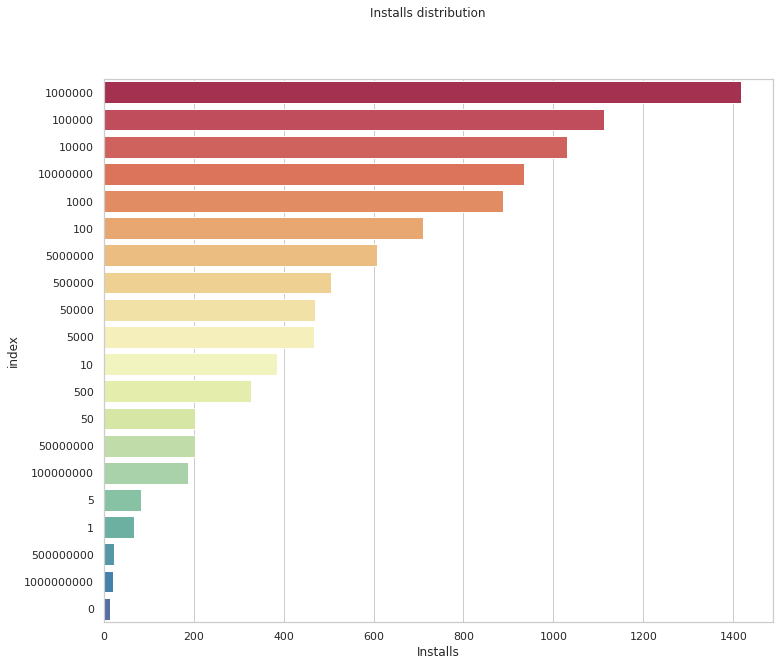

In [ ]:
# 1.000.000 is the most frequent number of installs
sns.set(style="whitegrid")
source_data = gps['Installs'].value_counts().to_frame().reset_index()
source_data['index'] = source_data['index'].astype(str)
sns.barplot(x='Installs', y='index', data=source_data, palette='Spectral')
plt.suptitle('Installs distribution', fontsize=12)
plt.show()

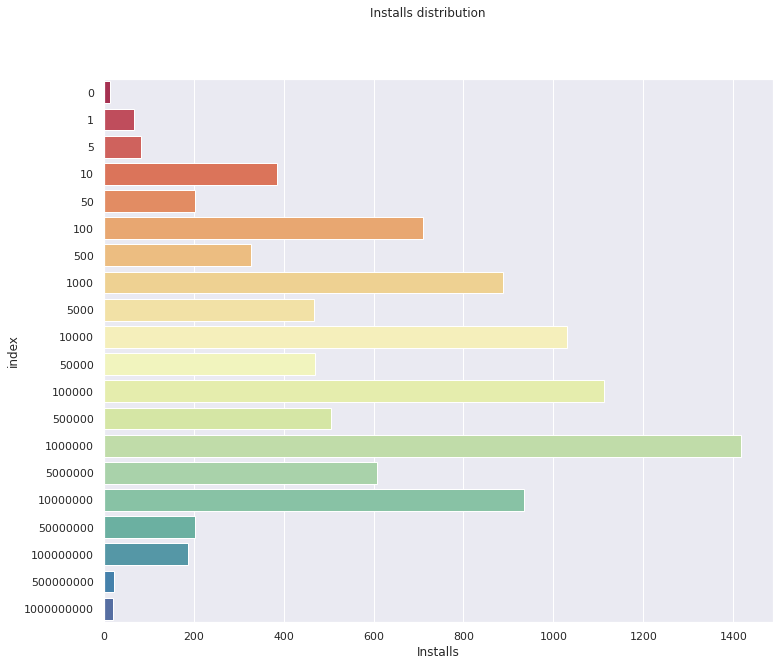

In [ ]:
# sorting by installs
source_data = gps['Installs'].value_counts().sort_index().to_frame().reset_index()
source_data['index'] = source_data['index'].astype(str)
sns.barplot(x='Installs', y='index', data=source_data, palette='Spectral')
plt.suptitle('Installs distribution', fontsize=12)
plt.show()

Text(0.5, 0.98, 'Installs distribution by Category')

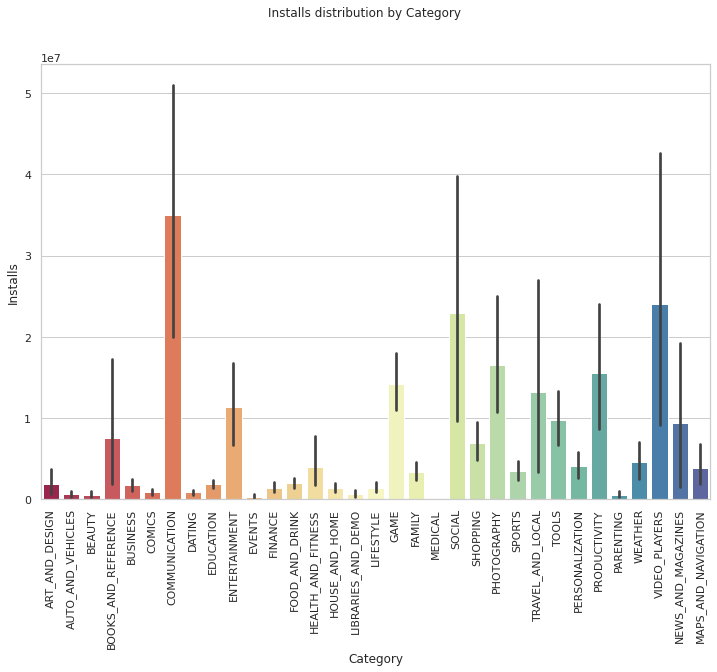

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))
source_data = gps[['Category', 'Installs']]
plt.xticks(rotation=90)
sns.barplot(x='Category',y='Installs', data=source_data, palette='Spectral')
plt.suptitle('Installs distribution by Category', fontsize=12)

### 7. Type
* check unique data - report as a table
* check data format and if it should be uniformed
* visualize frequency as a histogram or pie
* Can we do smth else?

In [ ]:
print('No. of nan: ',gps['Type'].isna().sum())
gps['Type'].unique()

No. of nan:  1


array(['Free', 'Paid', nan], dtype=object)

In [ ]:
gps[gps['Type'].isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,0.0,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device


In [ ]:
# maybe this row is useless, so we'll drop it
gps = gps[gps['Type'].notna()]

In [ ]:
print('Type distribution:\n')
type_vc = gps['Type'].value_counts()
type_vc

Type distribution:



Free    8902
Paid     756
Name: Type, dtype: int64

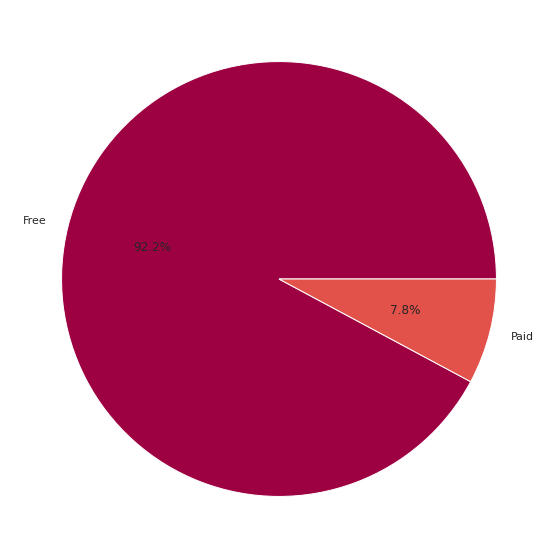

In [ ]:
plt.pie(type_vc.values, labels = type_vc.index, autopct='%1.1f%%', colors=pie_colors)
plt.show()

### 8. Price
* check unique data - report as a table
* check data format and if it should be uniformed. Now it is with '$, delete it and convert to numeric value
* Do we have outliers?
* visualize frequency as a histogram
* Check if each 'Free' in Type column corrispond to 0 in Price column
* Can we do smth else?

In [ ]:
gps['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$3.49',
       '$1.99', '$5.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$11.99', '$79.99', '$16.99', '$14.99', '$1.00',
       '$29.99', '$12.99', '$2.49', '$24.99', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [ ]:
# we just remove '$' and apply ceil
gps['Price'] = gps.apply(lambda row: re.sub(r'\$','', row['Price']), axis=1)
gps['Price'] = gps['Price'].astype(float)
gps['Price'] = gps.apply(lambda row: np.ceil(row['Price']), axis=1)
gps['Price'].unique()

array([  0.,   5.,   4.,   7.,   2.,   3.,   8.,   6.,  10.,   1.,   9.,
        12.,  80.,  17.,  15.,  30.,  13.,  25.,  11.,  20.,  16.,  34.,
        75.,  40.,  26., 400.,  18.,  14., 300., 380.,  38.,  19., 390.,
        47., 110., 155.,  29., 200.,  90.,  31., 395.])

In [ ]:
print('No. of nan: ',gps['Price'].isna().sum())
print()
print('Price distribution:\n')
price_vc = gps['Price'].value_counts().sort_index()
#price_vc = gps['Price'].value_counts()
price_vc

No. of nan:  0

Price distribution:



0.0      8902
1.0       148
2.0       135
3.0       155
4.0        72
5.0        87
6.0        31
7.0        16
8.0         9
9.0         8
10.0       21
11.0        2
12.0        3
13.0        4
14.0        3
15.0        9
16.0        2
17.0        2
18.0        2
19.0        1
20.0        7
25.0        3
26.0        1
29.0        1
30.0        5
31.0        1
34.0        1
38.0        1
40.0        2
47.0        1
75.0        1
80.0        1
90.0        1
110.0       1
155.0       1
200.0       1
300.0       1
380.0       1
390.0       1
395.0       1
400.0      13
Name: Price, dtype: int64

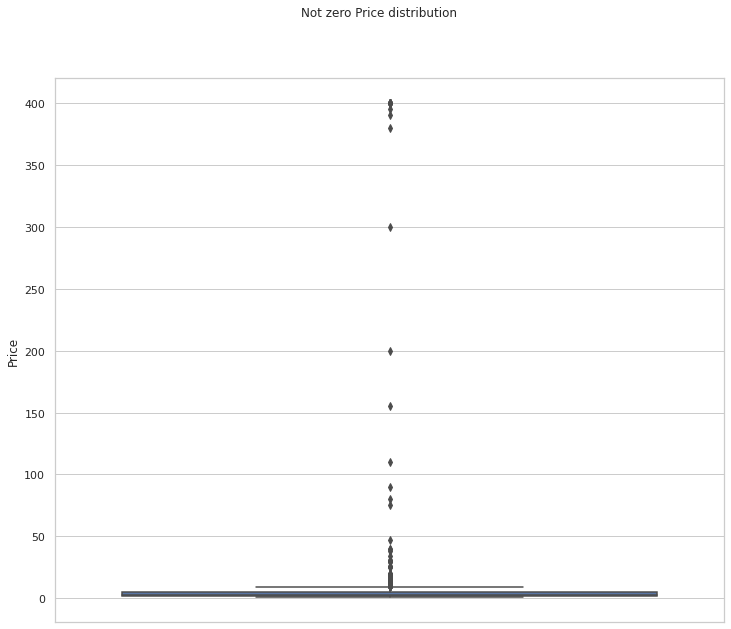

In [ ]:
sns.boxplot(y=gps[gps['Price'] != 0]['Price'])
plt.suptitle('Not zero Price distribution', fontsize=12)
plt.show()

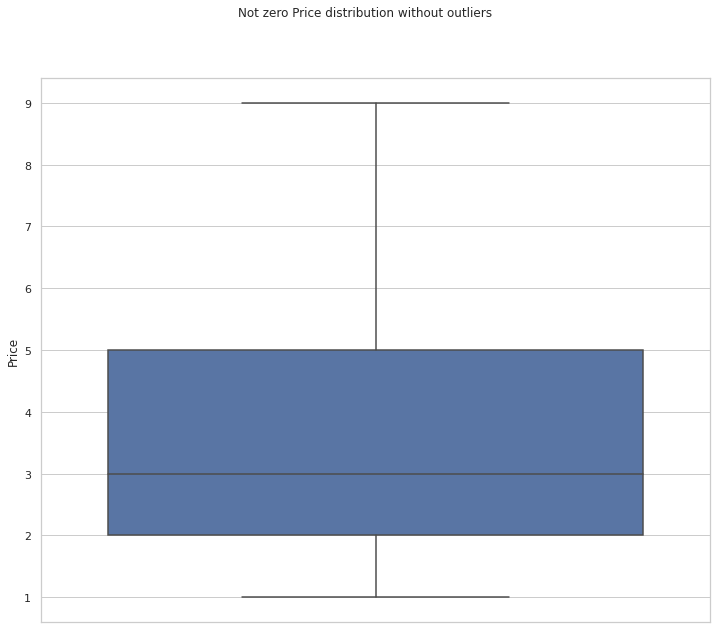

In [ ]:
# without outliers
sns.boxplot(y=gps[gps['Price'] != 0]['Price'], showfliers = False)
plt.suptitle('Not zero Price distribution without outliers', fontsize=12)
plt.show()

In [ ]:
gps[(gps['Price'] != 0)&(gps['Price'] < 100 )]['Price'].mean()

4.838315217391305

In [ ]:
# let's we have a look on extreme outliers
gps[gps['Price']> 50].sort_values(by=['Installs'], ascending=False)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
5351,I am rich,LIFESTYLE,3.8,3547,1.800,100000,Paid,400.0,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
5356,I Am Rich Premium,FINANCE,4.1,1867,4.700,50000,Paid,400.0,Everyone,Finance,"November 12, 2017",1.6,4.0 and up
4362,💎 I'm rich,LIFESTYLE,3.8,718,26.000,10000,Paid,400.0,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.300,10000,Paid,400.0,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
5354,I am Rich Plus,FAMILY,4.0,856,8.700,10000,Paid,400.0,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
5355,I am rich VIP,LIFESTYLE,3.8,411,2.600,10000,Paid,300.0,Everyone,Lifestyle,"July 21, 2018",1.1.1,4.3 and up
5366,I Am Rich,FAMILY,3.6,217,4.900,10000,Paid,390.0,Everyone,Entertainment,"June 22, 2018",1.5,4.2 and up
5359,I am rich(premium),FINANCE,3.5,472,0.965,5000,Paid,400.0,Everyone,Finance,"May 1, 2017",3.4,4.4 and up
5362,I Am Rich Pro,FAMILY,4.4,201,2.700,5000,Paid,400.0,Everyone,Entertainment,"May 30, 2017",1.54,1.6 and up
5369,I am Rich,FINANCE,4.3,180,3.800,5000,Paid,400.0,Everyone,Finance,"March 22, 2018",1.0,4.2 and up


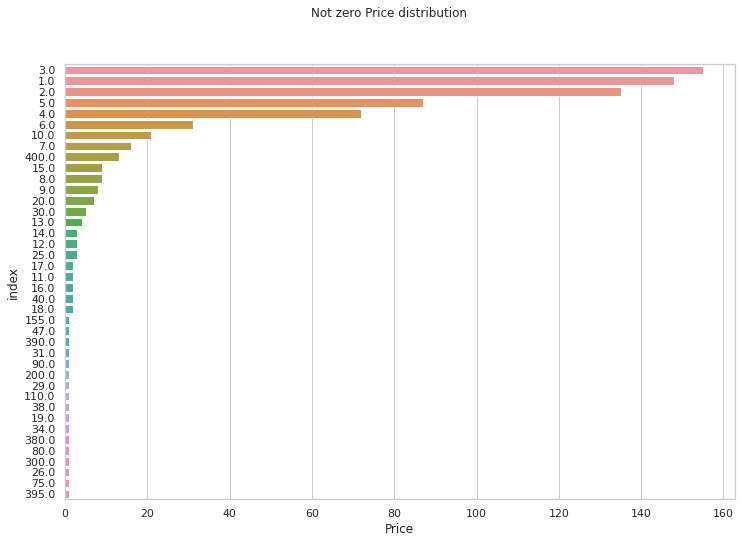

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))
source_data = gps[gps['Price'] != 0]['Price'].value_counts().to_frame().reset_index()
source_data['index'] = source_data['index'].astype(str)
sns.barplot(x='Price', y='index', data=source_data)
plt.suptitle('Not zero Price distribution', fontsize=12)
plt.show()

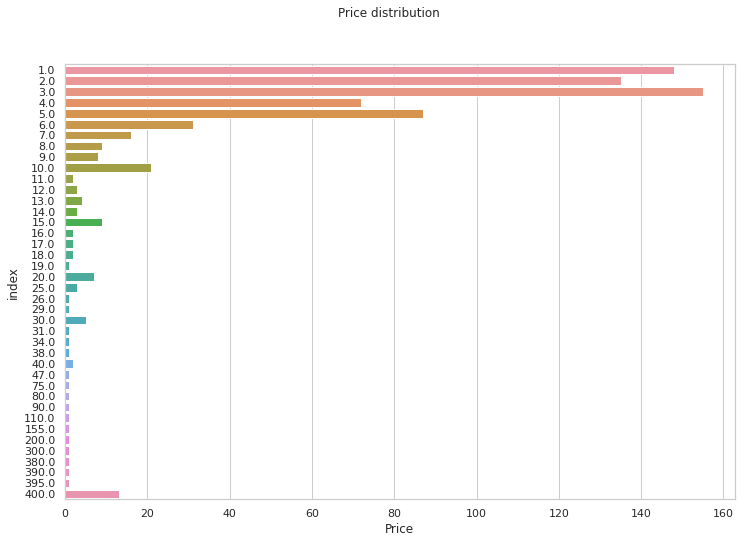

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,8))
source_data = gps[gps['Price'] != 0]['Price'].value_counts().sort_index().to_frame().reset_index()
source_data['index'] = source_data['index'].astype(str)
sns.barplot(x='Price', y='index', data=source_data)
plt.suptitle('Price distribution', fontsize=12)
plt.show()

In [ ]:
# Type == 'Free' <=> Price == 0 ?

gps[gps['Type'] == 'Free']['Price'].sum()
# '=>' OK

0.0

In [ ]:
gps[gps['Type'] == 'Paid'][gps['Price'] == 0].shape[0]
# '<=' OK

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0

### 9. Content rating
* check unique data and frequency - report as a table
* check data format and if it should be uniformed. Do we want to trasform it to age group, for example Everyone - 0, Teen - 13, Adult - 18 etc
* visualize frequency as a histogram 
* Can we do smth else?
    * _analise price, category and installs for each app rating segment? We could, for example, answer the question: what's the most popular children app?)_

In [ ]:
print('No. of nan: ',gps['Content Rating'].isna().sum())
print('\n')
print('Content Rating distribution:\n')
cr_vc = gps['Content Rating'].value_counts()
cr_vc

No. of nan:  0


Content Rating distribution:



Everyone           7903
Teen               1036
Mature 17+          393
Everyone 10+        321
Adults only 18+       3
Unrated               2
Name: Content Rating, dtype: int64

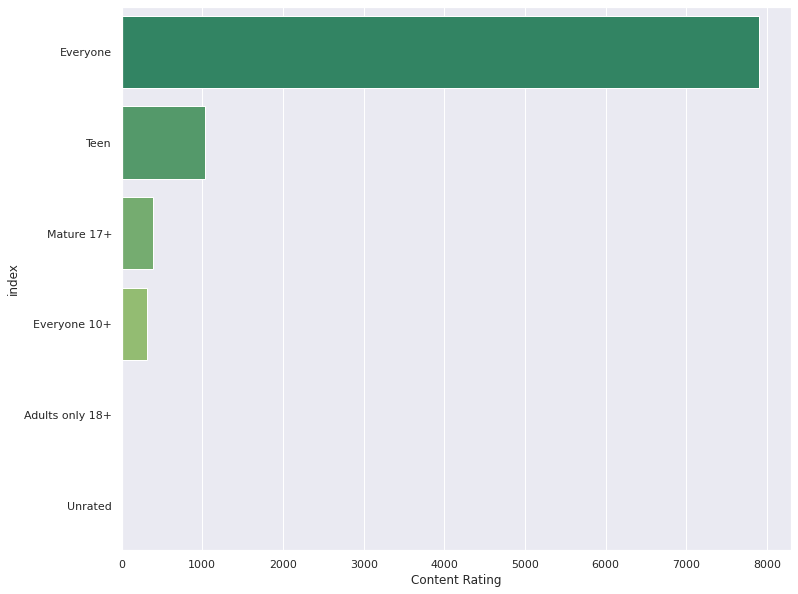

In [ ]:
sns.set(style="darkgrid")
sns.barplot(
    data=gps['Content Rating'].value_counts().to_frame().reset_index(),
    x='Content Rating',
    y='index',
    palette='summer')

In [ ]:
gps[gps['Content Rating'] == 'Unrated']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
7312,Best CG Photography,FAMILY,NaN,1,2.5,500,Free,0.0,Unrated,Entertainment,"June 24, 2015",5.2,3.0 and up
8266,DC Universe Online Map,TOOLS,4.1,1186,6.4,50000,Free,0.0,Unrated,Tools,"February 27, 2012",1.3,2.3.3 and up


In [ ]:
gps[gps['Content Rating'] == 'Unrated']['App'].values

array(['Best CG Photography', 'DC Universe Online Map'], dtype=object)

In [ ]:
gps[gps['Content Rating'] == 'Adults only 18+']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
298,Manga Master - Best manga & comic reader,COMICS,4.6,24005,4.9,500000,Free,0.0,Adults only 18+,Comics,"July 4, 2018",1.1.7.0,4.1 and up
3043,DraftKings - Daily Fantasy Sports,SPORTS,4.5,50017,41.0,1000000,Free,0.0,Adults only 18+,Sports,"July 24, 2018",3.21.324,4.4 and up
6424,Manga Books,COMICS,3.8,7326,0.0,500000,Free,0.0,Adults only 18+,Comics,"August 3, 2018",Varies with device,Varies with device


In [ ]:
gps[gps['Content Rating'] == 'Adults only 18+']['App'].values

array(['Manga Master - Best manga & comic reader',
       'DraftKings - Daily Fantasy Sports', 'Manga Books'], dtype=object)

### 10. Genres
* check unique data - report as a table
* check data format and if it should be uniformed

Some Genres are created as 'Art & Design;Pretend Play', we can split it in 2 columns: 'Genres' and 'Subgenres' _(from enrico: I don't think there's a hirearchical dependency between values separated with semicolon, but I suspect there is one between "CATEGORY" column and each of the values in "Genre" -- I can expect one app to be either in "GAMES" or a "TOOLS" category; while a game can be of genre "Action" and "Educational" at the same time)_
* check unique data and frequency for both 2 columns that are created

* visualize frequency as a histogram or pie for both columns
* Can we do smth else?
    * _for each category+genre1/2 (or maybe just category) combination:_
        * _avg, p50 and p90 for number of installs_
        * _avg, p50 and p90 price_
        * _avg, p50 and p90 rating_
        * _most popular apps per genre?_




In [ ]:
print('No. of nan: ',gps['Genres'].isna().sum())
print('\n')
print('Genres distribution:\n')
genres_vc = gps['Genres'].value_counts()
genres_vc

No. of nan:  0


Genres distribution:



Tools                       827
Entertainment               561
Education                   510
Business                    420
Medical                     395
                           ... 
Comics;Creativity             1
Entertainment;Education       1
Role Playing;Education        1
Role Playing;Brain Games      1
Tools;Education               1
Name: Genres, Length: 119, dtype: int64

In [ ]:
# How many additional categories do we expect
gps['Genres count'] = gps['Genres'].str.count(';')
gps['Genres count'].value_counts()

0    9263
1     395
Name: Genres count, dtype: int64

In [ ]:
# split Genres into their own column
gps[['Genre 1','Genre 2']] = gps['Genres'].str.split(';', expand=True)

In [ ]:
# display the distribution for Genres #1
genres1 = gps[['Category', 'Genre 1']].rename(columns={"Genre 1":"Genre"})
genres1_vc = genres1['Genre'].value_counts()
genres1_vc

Tools                      828
Entertainment              592
Education                  580
Business                   420
Medical                    395
Personalization            376
Productivity               374
Lifestyle                  370
Finance                    345
Sports                     335
Communication              316
Action                     311
Health & Fitness           290
Photography                281
News & Magazines           254
Social                     239
Books & Reference          225
Casual                     224
Travel & Local             219
Simulation                 206
Shopping                   202
Arcade                     199
Dating                     171
Video Players & Editors    165
Puzzle                     143
Maps & Navigation          131
Role Playing               115
Food & Drink               112
Racing                     108
Educational                102
Strategy                    98
Auto & Vehicles             85
Librarie

In [ ]:
# display the distribution for Genres #2
genres2 = gps[['Category', 'Genre 2']].rename(columns={"Genre 2":"Genre"})
genres2_vc = genres2['Genre'].value_counts()
genres2_vc

Education             98
Action & Adventure    98
Pretend Play          69
Brain Games           66
Creativity            33
Music & Video         31
Name: Genre, dtype: int64

In [ ]:
all_genres = pd.concat([genres1, genres2], ignore_index=True)
all_genres_vc = all_genres.value_counts()
all_genres_vc

Category  Genre                  
TOOLS     Tools                      828
FAMILY    Education                  557
          Entertainment              505
BUSINESS  Business                   420
MEDICAL   Medical                    395
                                    ... 
FAMILY    Lifestyle                    1
          Music & Audio                1
GAME      Education                    1
FAMILY    Video Players & Editors      1
          Trivia                       1
Length: 94, dtype: int64

In [ ]:
# find which genres in each main app category
group = all_genres.groupby(['Category','Genre']).size()
group

Category             Genre                  
ART_AND_DESIGN       Art & Design                61
                     Creativity                   4
AUTO_AND_VEHICLES    Auto & Vehicles             85
BEAUTY               Beauty                      53
BOOKS_AND_REFERENCE  Books & Reference          222
                                               ... 
TRAVEL_AND_LOCAL     Travel & Local             219
VIDEO_PLAYERS        Creativity                   1
                     Music & Video                1
                     Video Players & Editors    164
WEATHER              Weather                     79
Length: 94, dtype: int64

In [ ]:
source_data = all_genres_vc.to_frame().reset_index()
source_data["Category/Genre"] = source_data["Category"].str.cat(source_data["Genre"], sep =" - ")
source_data = source_data.drop(columns=["Category", "Genre"]).rename(columns={0:"Count"})

# filter out those with less than 100 apps
source_data[source_data['Count']>=100]

,Count,Category/Genre
0,828,TOOLS - Tools
1,557,FAMILY - Education
2,505,FAMILY - Entertainment
3,420,BUSINESS - Business
4,395,MEDICAL - Medical
5,376,PERSONALIZATION - Personalization
6,374,PRODUCTIVITY - Productivity
7,369,LIFESTYLE - Lifestyle
8,345,FINANCE - Finance
9,325,SPORTS - Sports


In [ ]:
# plot graph only for Category/Genre with at least 100 apps
sns.set(style="darkgrid")
plt.figure(figsize=(20,8))
sns.barplot(y='Category/Genre', x='Count', data=source_data[source_data['Count']>=100], palette='Set2')
plt.suptitle('Genres Category distribution', fontsize=12)

KeyError: ignored

<Figure size 1440x576 with 0 Axes>

### 11. Last Update

* conver data format do Datetime
* check unique data 
* we can introduce once more column or just change this one to date from last update for example, thus we will understand how old it the last version
* visualize frequency as a histogram probably grouped by bins
* Can we do smth else?
    * we don't know when the snapshot was taken, so should we set last update as relative to `gps['Last_Updated_Days'].min()`

In [ ]:
from datetime import datetime, date

print('Current format: ', gps['Last Updated'][0])

Current format:  January 7, 2018


In [ ]:
# One row has the value 'Last Update' = 1.0.19, I think we can drop it
display(gps[gps['Last Updated'] == '1.0.19'])

gps = gps.drop(gps[gps['Last Updated'] == '1.0.19'].index)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Genres count,Genre 1,Genre 2


In [ ]:
# we can add this serie as a converted column
last_update_convert = pd.to_datetime(gps['Last Updated'])
last_update_convert.head()

0   2018-01-07
2   2018-08-01
3   2018-06-08
4   2018-06-20
5   2017-03-26
Name: Last Updated, dtype: datetime64[ns]

In [ ]:
# or we can add directly calculated column
gps['Last_Updated_Days'] = last_update_convert.apply(lambda x:(date.today()-datetime.date(x)).days)
gps['Last_Updated_Days'].head(15)

0     1044
2      838
3      892
4      880
5     1331
6      935
7      886
8     1153
9      867
10    1116
11     839
12     959
13     874
14     836
15     894
Name: Last_Updated_Days, dtype: int64

In [ ]:
min_update_days = gps['Last_Updated_Days'].min()
print('Min days from last update: ', min_update_days)

max_update_days = gps['Last_Updated_Days'].max()
print('Max days from last update: ', max_update_days)

Min days from last update:  831
Max days from last update:  3832


In [ ]:
gps['Last_Updated_Days_Relative'] = gps['Last_Updated_Days'].apply(lambda x:x-min_update_days)
gps['Last_Updated_Days_Relative'].head(15)

0     213
2       7
3      61
4      49
5     500
6     104
7      55
8     322
9      36
10    285
11      8
12    128
13     43
14      5
15     63
Name: Last_Updated_Days_Relative, dtype: int64

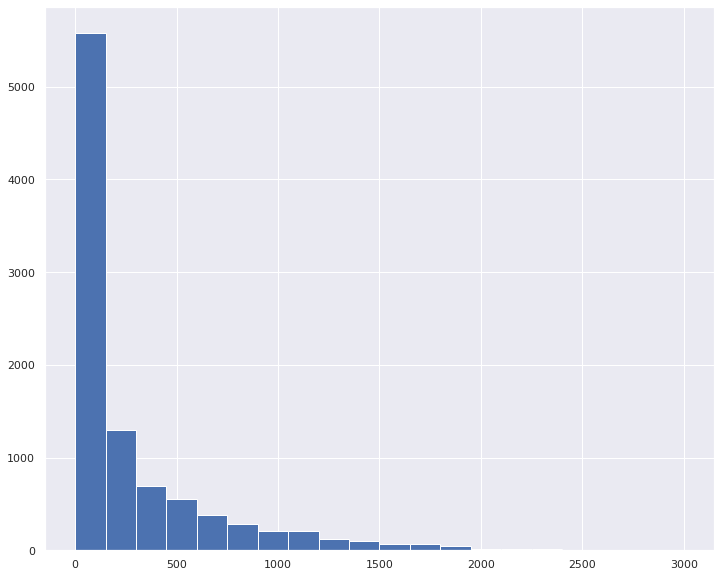

In [ ]:
# graph all
gps['Last_Updated_Days_Relative'].hist(bins=20)

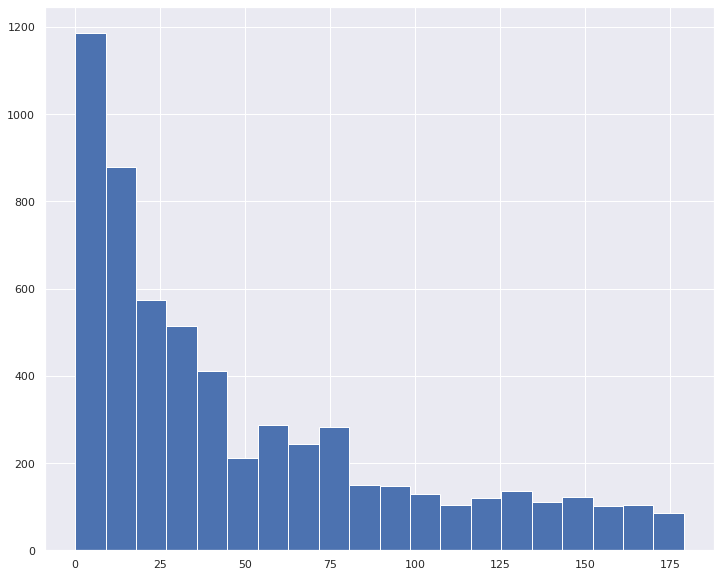

In [ ]:
# zoom into those updated in the last 6 months
gps_recently_updated = gps[gps['Last_Updated_Days_Relative']<180]
gps_recently_updated['Last_Updated_Days_Relative'].hist(bins=20)

**Result**:
* the major part of the applications were updated in last 6 months prior to the snapshot
* the snapshot appears to be more than 2 years old


### 12. Current Version
* check unique data - report as a table
* check data format and if it should be uniformed
* is there sense to split version (4.0.1 -> 4 | 0 | 1) and take the first value as the last base version?
* visualize frequency as a histogram
* Can we do smth else?

In [ ]:
print('No. of nan: ',gps['Current Ver'].isna().sum())
print()
print('Current version distribution:\n')
current_ver = gps['Current Ver'].value_counts()
current_ver

No. of nan:  8

Current version distribution:



Varies with device    1054
1.0                    798
1.1                    260
1.2                    176
2.0                    149
                      ... 
01.01.66                 1
1.161.10002              1
5.42.1                   1
4.0.8                    1
4.9.31                   1
Name: Current Ver, Length: 2818, dtype: int64

In [ ]:
np.random.choice(gps['Current Ver'].unique(), 1000)

# Work with anomalies
# 'Varies with device' - Should we replace it?
# 'R6.0.3'
# 'v1.8b22p13'
# '01'
# '2018.07' - seems more like a date
# Cannonau 3.11.11
# Public.Heal

# I'm not sure what to do with all of it

array(['6.7.24.2018', '4.1.202', '3.18.5', '5.9.5', '3.8.75a',
       '4.1.5 (Steglitz)', '1.14.1', '33.0', '2.71', '2.1.54', '1.28',
       '2.54.3', '9.7.6', '0.1.7', '1.3.35',
       'airConditionerMaintenance_13112015', '8.6.2', '4.2.2', 'V4.1.0',
       '5.3.0', '1.0.4', '1.18.34', '1.911.1944.4606', 'v2.6.0', '1.26.2',
       '2.15.1', '4.9.0', '1.0.142', '8.5', '2.2 (Protostar)', '1.7',
       '5.9.1', '1.5.3', '1.0.204375696', '2.00.00', '39.231',
       '4.5.28_ww', '6.24', '4.18.0', '2.17', '8.25.10.01', '1.0.8',
       '1.0.261', '2.3.3-play', '2.003', '3.53', '1.9.5', '5.9.006',
       '1.41', '3.0.231.18141', '1.20180531.3', '1.7.1', '1.9.9.5',
       '2.0.0 (18.03.01)', 'pb1.0.0.1', '2.2.0.23', '2.4.3', '2.09',
       '7.3(823181)', '2.05', '3.0.8', '2.0.180226.1', '6.17.2', '18.7.1',
       '1.14.1', '1.8.0716', '2.0.0(9)', '8.3.0', '6.1.1', '1.5.14',
       '2.2.0', '2.45', '1.932', '3.12', '2.4.5', '20180620', '4.8.5',
       '5.2.5', '16.0.0.437', '4.0.10', '102.0.875

### 13. Android Version
* check unique data - report as a table
* check data format and if it should be uniformed: for example 'and up' can be delete, 'Varies with device' can be convert to null
* check unique data and frequency
* is there sense to split version (4.0.1 -> 4 | 0 | 1) and take the first value as the min android version? 
* visualize frequency as a histogram
* Can we do smth else?

In [ ]:
print('No. of nan: ',gps['Android Ver'].isna().sum())
print()
print('Android version distribution:\n')
android_ver = gps['Android Ver'].value_counts()
android_ver

No. of nan:  2

Android version distribution:



4.1 and up            2203
4.0.3 and up          1394
4.0 and up            1285
Varies with device     989
4.4 and up             818
2.3 and up             617
5.0 and up             512
4.2 and up             372
2.3.3 and up           273
2.2 and up             239
3.0 and up             230
4.3 and up             221
2.1 and up             133
1.6 and up             116
6.0 and up              54
7.0 and up              42
3.2 and up              36
2.0 and up              32
5.1 and up              22
1.5 and up              20
4.4W and up             11
3.1 and up              10
2.0.1 and up             7
8.0 and up               6
7.1 and up               3
5.0 - 8.0                2
4.0.3 - 7.1.1            2
1.0 and up               2
5.0 - 7.1.1              1
4.1 - 7.1.1              1
5.0 - 6.0                1
2.2 - 7.1.1              1
7.0 - 7.1.1              1
Name: Android Ver, dtype: int64

In [ ]:
# drop 'and up'
gps['Android Ver'] = gps['Android Ver'].str.replace(r' and up$', '')
# drop 'W' to uniform 
gps['Android Ver'] = gps['Android Ver'].str.replace(r'W$', '')
# keep only start version
gps['Android Ver'] = gps['Android Ver'].str.split('-').str[0]
# replace 'Varies with device' to -1. We can decide if it is necessary....
gps['Android Ver'] = gps['Android Ver'].str.replace(r'Varies with device', '-1')

Text(0.5, 0.98, 'Android Ver distribution')

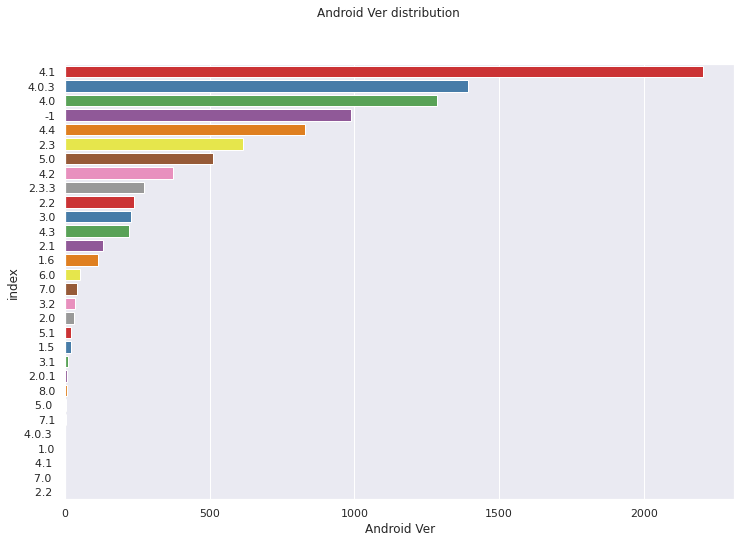

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12,8))
source_data = gps['Android Ver'].value_counts().to_frame().reset_index()
source_data['index'] = source_data['index'].astype(str)
sns.barplot(x='Android Ver', y='index', data=source_data, palette='Set1')
plt.suptitle('Android Ver distribution', fontsize=12)

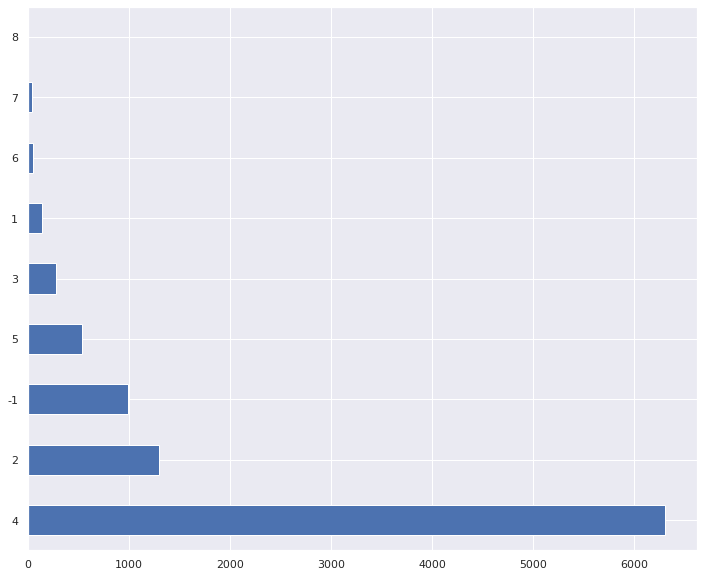

In [ ]:
# Split Android version on the first '.' and create a column 'Android Base Version' to understand the most popular android base vesion
gps['Android Base Version'] = gps['Android Ver'].str.split('.').str[0]
gps['Android Base Version'].value_counts().plot(kind='barh')

Result:
* seems that most are compatible with at least Android v4
* very few target only the most recent OS version

# II. **googleplaystore_user_reviews.csv**

Check number of columns, columns types.

In [ ]:
%matplotlib inline
gps_ur.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [ ]:
print("googleplaystore_user_reviews.csv shape: ", gps_ur.shape)

googleplaystore_user_reviews.csv shape:  (64295, 5)


In [ ]:
print("googleplaystore_user_reviews.csv columns: ", list(gps_ur.columns))

googleplaystore_user_reviews.csv columns:  ['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity', 'Sentiment_Subjectivity']


In [ ]:
print("Column types:\n", gps_ur.dtypes)

Column types:
 App                        object
Translated_Review          object
Sentiment                  object
Sentiment_Polarity        float64
Sentiment_Subjectivity    float64
dtype: object


In [ ]:
#check null values in df
gps_ur.isnull().values.any()
print("Number of NaN rows: ", gps_ur.isnull().sum())

Number of NaN rows:  App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64


In [ ]:
# drop nan rows as don't give information
gps_ur = gps_ur.dropna()
print("Number of Nan values: ", gps_ur.isnull().values.any())
print("googleplaystore_user_reviews.csv shape after drop Nan: ", gps_ur.shape)

Number of Nan values:  False
googleplaystore_user_reviews.csv shape after drop Nan:  (37427, 5)


### 1. App
* check unique data and frequency - report as a table
* report frequency as a hisrogram
* Can we do smth else?

Rows for each app


Bowmasters                                            312
Angry Birds Classic                                   273
Helix Jump                                            273
Calorie Counter - MyFitnessPal                        254
Candy Crush Saga                                      240
                                                     ... 
Calculator - unit converter                             1
Drawing for Kids Learning Games for Toddlers age 3      1
Draw In                                                 1
Google Trips - Travel Planner                           1
Free Live Talk-Video Call                               1
Name: App, Length: 865, dtype: int64

----------------------------------------------------
Number of unique app values:  865
----------------------------------------------------
First 20 app with the highest distribution


Text(0.5, 0.98, 'App distribution')

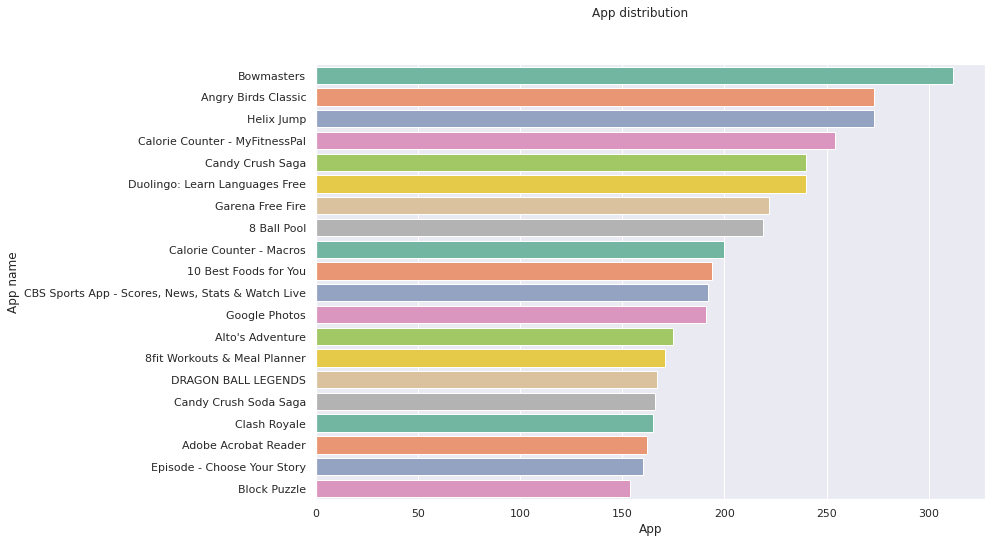

In [ ]:
print("Rows for each app")
display(gps_ur['App'].value_counts())
print("----------------------------------------------------")
print("Number of unique app values: ", len(gps_ur['App'].unique()))
print("----------------------------------------------------")
print("First 20 app with the highest distribution")
sns.set(style="darkgrid")
plt.figure(figsize=(12,8))
source_data = gps_ur['App'].value_counts().to_frame().reset_index()[0:20]
source_data['App name'] = source_data['index'].astype(str)
sns.barplot(x='App', y='App name', data=source_data, palette='Set2')
plt.suptitle('App distribution', fontsize=12)

Number of unique values in application in first table: **9659**. Instead the second table have only 865 unque application.

So we have reviews for less than 10% of the apps of the first file.

### 2. Translated Review

* check how many nan 

In [ ]:
gps_ur["Translated_Review"].isnull().values.any()
print("Number of NaN reviews: ", gps_ur["Translated_Review"].isnull().sum())

Number of NaN reviews:  0


In [ ]:
gps_ur["Translated_Review"].head()

0    I like eat delicious food. That's I'm cooking ...
1      This help eating healthy exercise regular basis
3           Works great especially going grocery store
4                                         Best idea us
5                                             Best way
Name: Translated_Review, dtype: object

### 3. Sentiment
* check unique data and frequency
* should data be modify/preprocessed?
* display frequency as a historram
* Can we do smth else?

['Positive' 'Neutral' 'Negative']


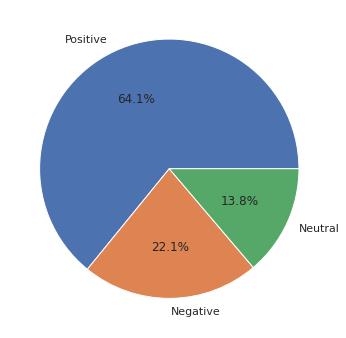

In [ ]:
print(gps_ur['Sentiment'].unique())

fig = plt.figure(figsize=(5,5)) 
labels = gps_ur['Sentiment'].value_counts(sort = True).index
sizes = gps_ur['Sentiment'].value_counts(sort = True)

plt.pie(sizes,labels=labels,autopct='%1.1f%%')
plt.tight_layout()
plt.show()

In [ ]:
print("Positive example")
display(gps_ur[gps_ur['Sentiment'] == "Positive"].head(1))

print()

print("Negative example")
display(gps_ur[gps_ur['Sentiment'] == "Negative"].head(1))

print()

print("Neutral example")
display(gps_ur[gps_ur['Sentiment'] == "Neutral"].head(1))

Positive example


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.0,0.533333



Negative example


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
32,10 Best Foods for You,No recipe book Unable recipe book.,Negative,-0.5,0.5



Neutral example


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
8,10 Best Foods for You,"Looking forward app,",Neutral,0.0,0.0


### 4. Sentiment Polarity

* check unique data and frequency - report as a table
* check data format and if it should be uniformed
* visualize frequency as a histogram 
* Can we do smth else?

Min value of sentiment polarity:  -1.0
Max value of sentiment polarity:  1.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


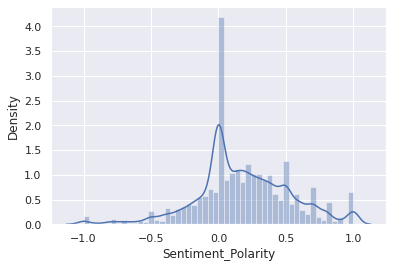

In [ ]:
print("Min value of sentiment polarity: ", min(gps_ur['Sentiment_Polarity']))
print("Max value of sentiment polarity: ", max(gps_ur['Sentiment_Polarity']))

ax = sns.distplot(gps_ur['Sentiment_Polarity'])

Sentiment polarity distribution is from -1 to 1 with the pick in 0

In [ ]:
# Sentiment Polarity when Sentiment is Neutral is **ALWAYS** equal to 0 
gps_ur[gps_ur['Sentiment'] == "Neutral"]['Sentiment_Polarity'].unique()

array([0.])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Distribution of neutral sentiment polarity')

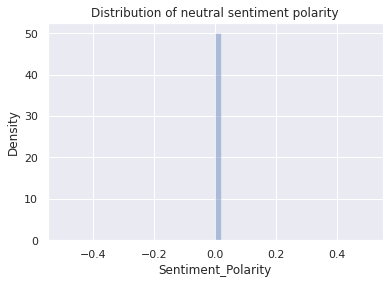

In [ ]:
ax = sns.distplot(gps_ur[gps_ur['Sentiment'] == "Neutral"]['Sentiment_Polarity'])
ax.set_title("Distribution of neutral sentiment polarity")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of positive sentiment polarity')

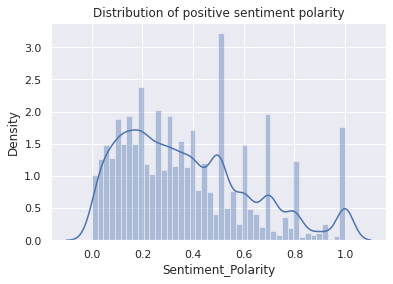

In [ ]:
ax = sns.distplot(gps_ur[gps_ur['Sentiment'] == "Positive"]['Sentiment_Polarity'])
ax.set_title("Distribution of positive sentiment polarity")

Positive sentiment returns only positive polarity


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of negative sentiment polarity')

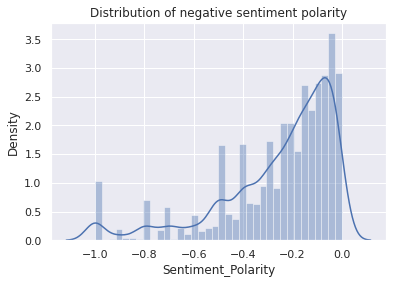

In [ ]:
ax = sns.distplot(gps_ur[gps_ur['Sentiment'] == "Negative"]['Sentiment_Polarity'])
ax.set_title("Distribution of negative sentiment polarity")

Negative sentiment returns only negative polarity

### 5. Sentiment Subjectivity

* check unique data and frequency - report as a table
* check data format and if it should be uniformed. Do we want to trasform it to age group, for example Everyone - 0, Teen - 13, Adult - 18 etc
* visualize frequency as a histogram 
* Can we do smth else?

Min value of sentiment subjectivity:  0.0
Max value of sentiment subjectivity:  1.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


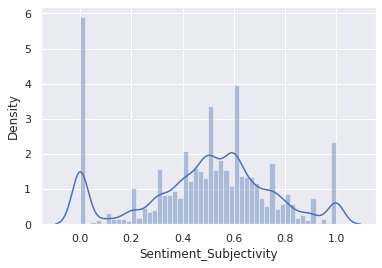

In [ ]:
print("Min value of sentiment subjectivity: ", min(gps_ur['Sentiment_Subjectivity']))
print("Max value of sentiment subjectivity: ", max(gps_ur['Sentiment_Subjectivity']))

ax = sns.distplot(gps_ur['Sentiment_Subjectivity'])

Sentiment_Subjectivity from 0 to 1

# STATISTICAL ANALYSIS
## Explore the relation of the data

Try to answer on the questions:


1.   How the price impact rating
2.   How the size impact rating
3.   How the category/genres impact rating 
4.   How the content rating impact rating

In [9]:
# load pre-processed data
downloaded = drive.CreateFile({'id':"1Vu8EXCXWrQXaB2VrfR8HFkjyhLo5fFOY"})
downloaded.GetContentFile('googleplaystore-preprocessed.parquet') 
gps_preprocessed = pd.read_parquet("googleplaystore-preprocessed.parquet")
gps = gps_preprocessed.copy() # working copy

downloaded = drive.CreateFile({'id':"1QTvmnIkaUs3Z6vxCf6Xkuy_yi0qfjxf2"})
downloaded.GetContentFile('googleplaystore_user_reviews-preprocessed.parquet')
gps_ur_preprocessed = pd.read_parquet('googleplaystore_user_reviews-preprocessed.parquet')
gps_ur = gps_ur_preprocessed.copy() # working copy

## Google Play Store

*Birds eye view (using 10% of data) on correlations using pairplot and custom pairgrid...*

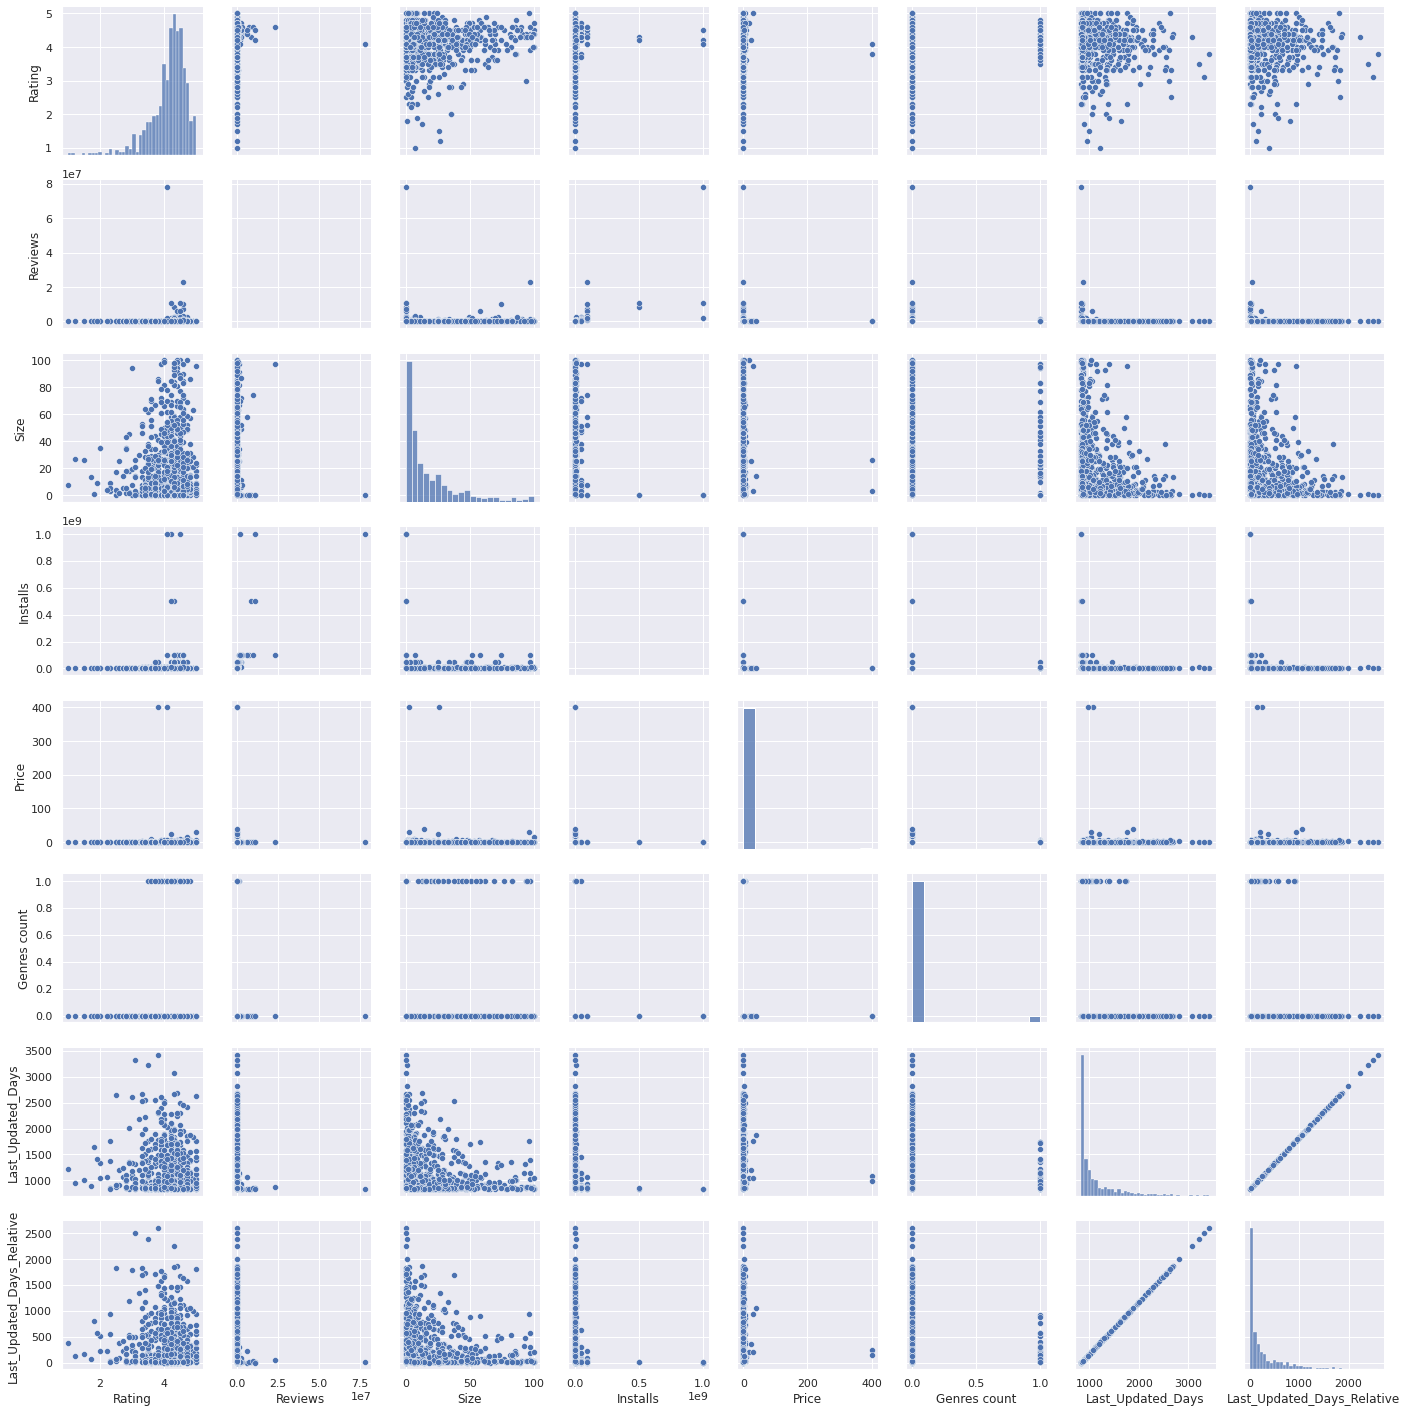

In [ ]:
gps_sample = gps.sample(frac=.10)
sns.pairplot(gps_sample)

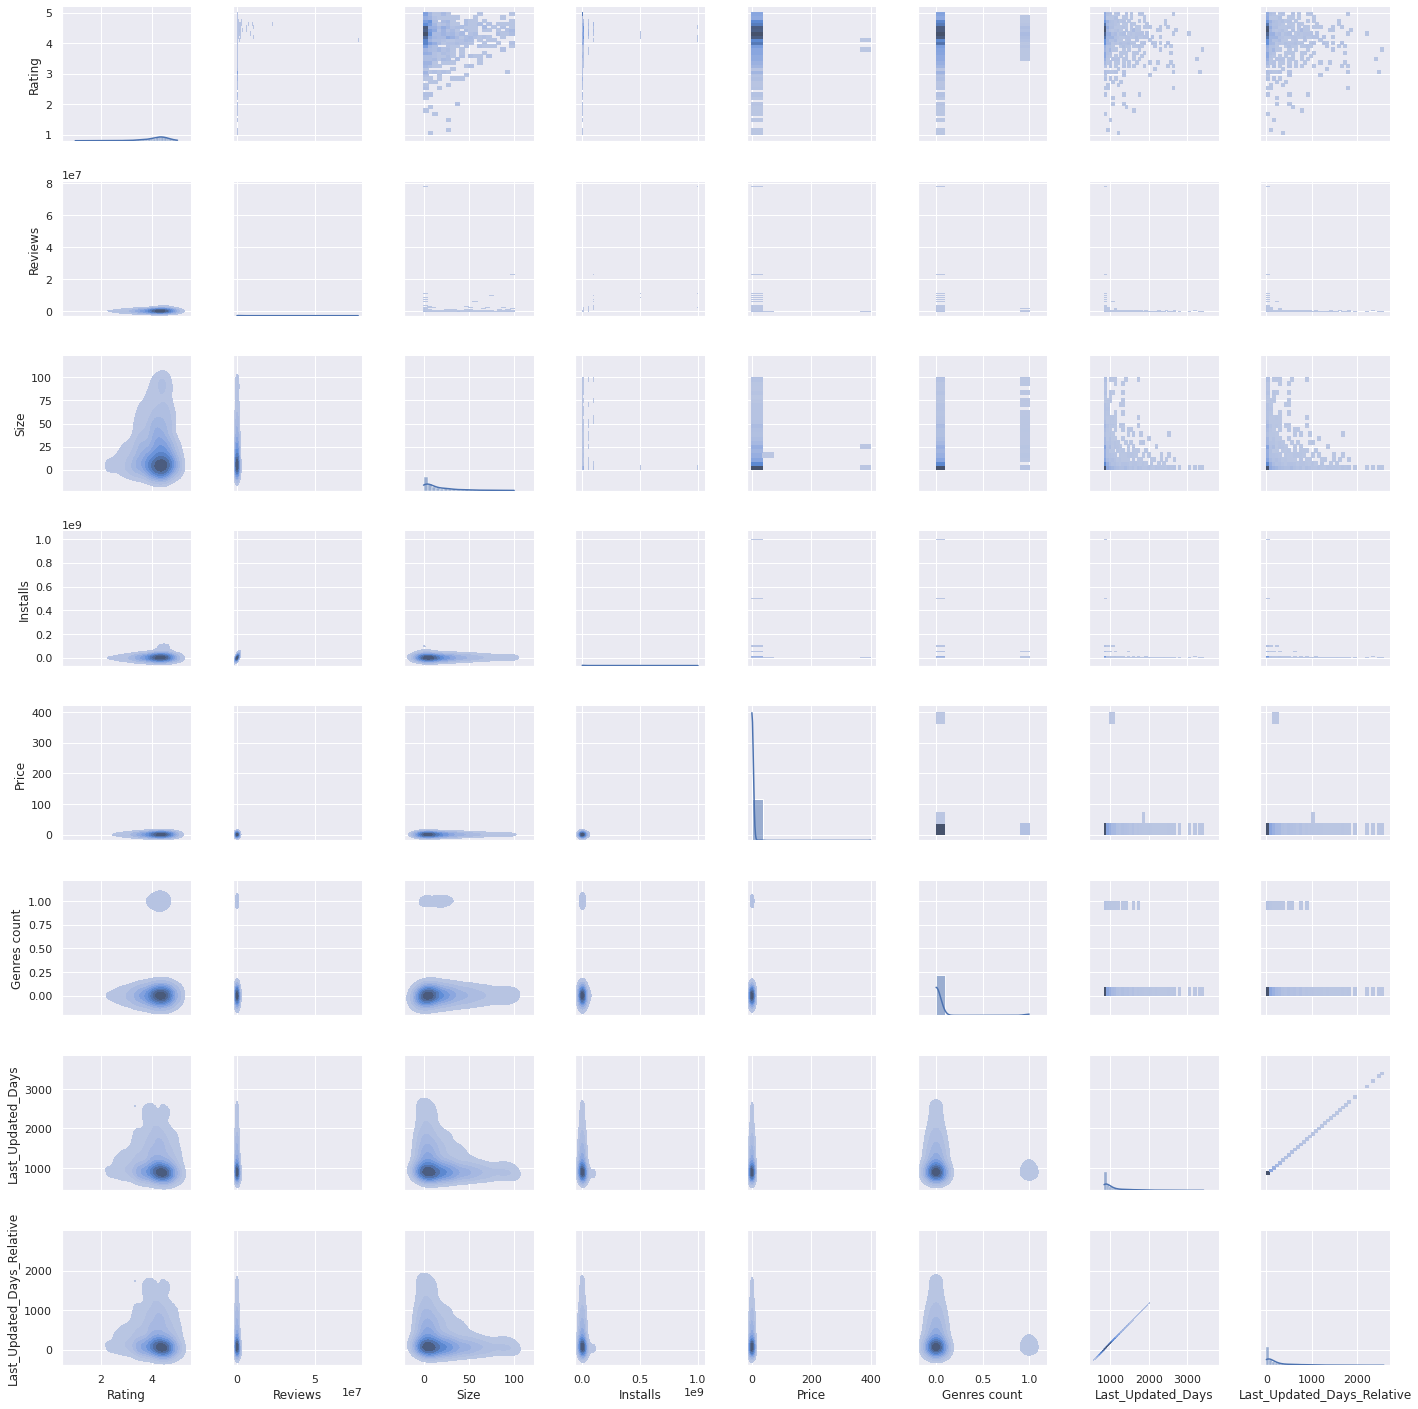

In [ ]:
g = sns.PairGrid(gps_sample)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

### Rating vs Content Rating

Text(0.5, 1.0, 'Box plot Rating VS Content Rating')

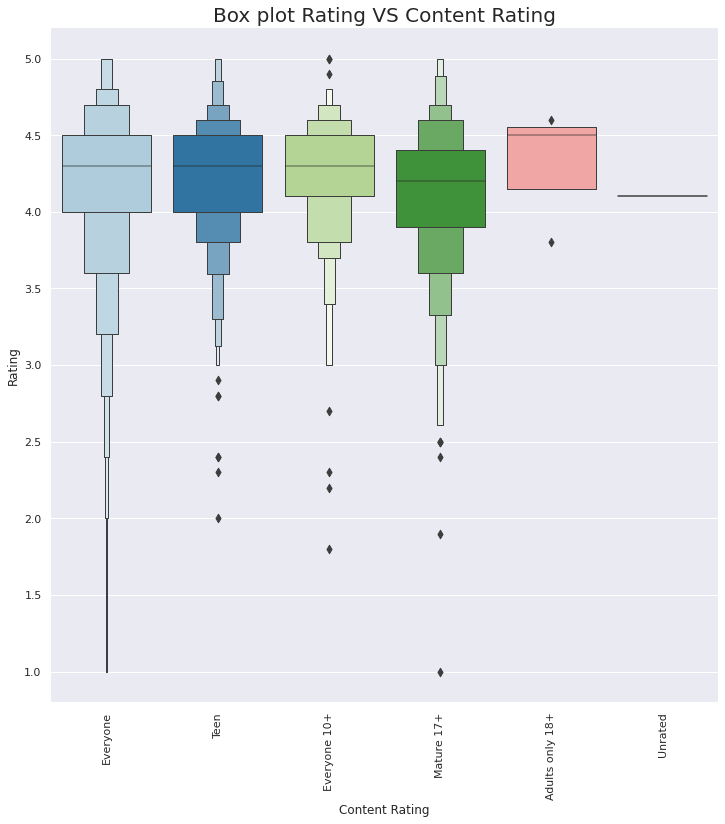

In [ ]:
# content rating VS rating
g = sns.catplot(x="Content Rating",y="Rating",data=gps, kind="boxen", height = 10 ,palette = "Paired")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Rating")
plt.title('Box plot Rating VS Content Rating',size = 20)

### Rating vs Category

Text(0.5, 1.0, 'Boxenplot of Rating VS Category')

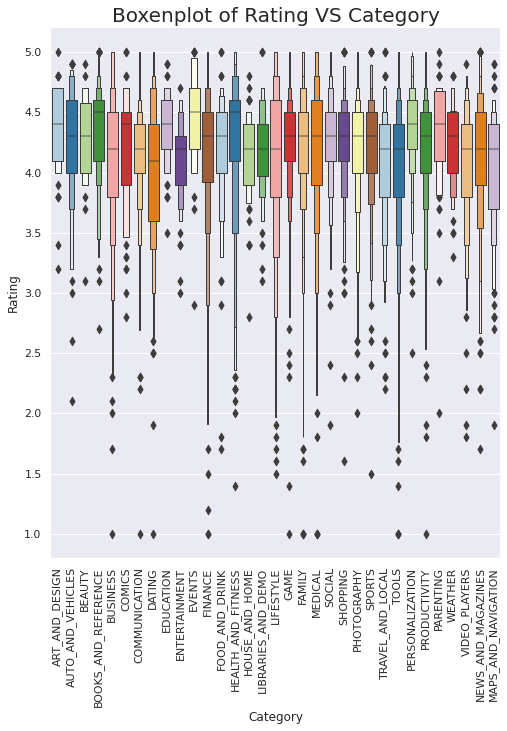

In [ ]:
#df = df.drop(df[df.score < 50].index)
#gps = gps.drop(gps[gps['Category'] == '1.9'].index)

g = sns.catplot(x="Category",y="Rating",data=gps, kind="boxen", height = 8 ,palette = "Paired")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Rating")
plt.title('Boxenplot of Rating VS Category',size = 20)

In [ ]:
print(gps.Rating[gps['Category'] == 'HEALTH_AND_FITNESS'].mean())
print(gps.Rating[gps['Category'] == 'BOOKS_AND_REFERENCE'].mean())
print(gps.Rating[gps['Category'] == 'DATING'].mean())

4.243032786885245
4.344970414201184
3.9701492537313423


How many apps have a lot of installs, but poor rating?

* a lot of installs: 2nd quantile (>p50 & <p75)
* poor rating: 1st quantile (<p25)


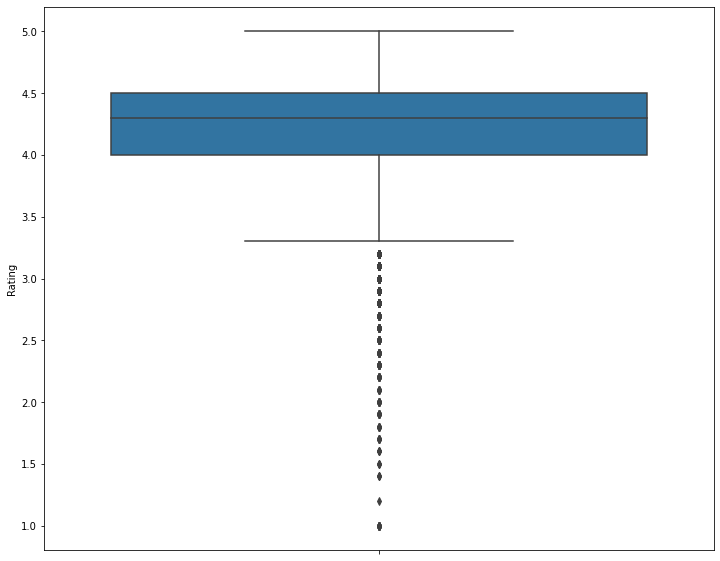

In [11]:
sns.boxplot(y=gps['Rating'])

In [12]:
poor_rating = gps['Rating'].quantile(.25)
poor_rating

4.0

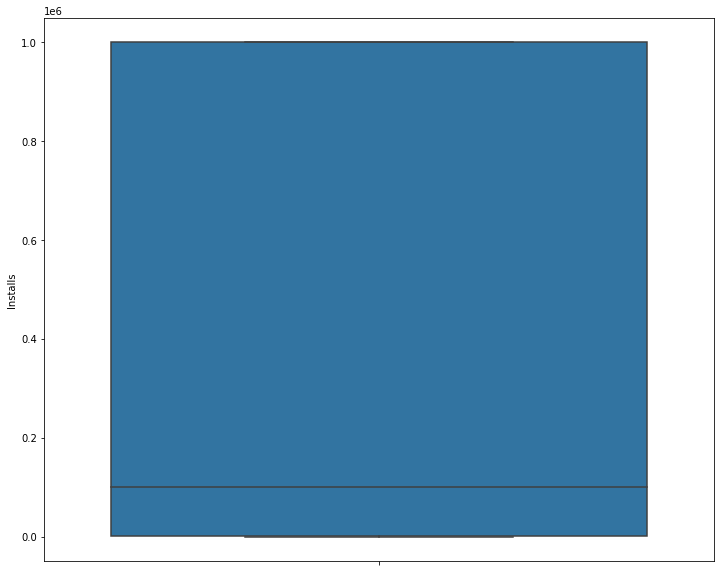

In [13]:
sns.boxplot(y=gps['Installs'], showfliers = False)

In [19]:
installs_min = gps['Installs'].quantile(.50)
installs_min

100000.0

In [20]:
installs_max = gps['Installs'].quantile(.95)
installs_max

10000000.0

In [21]:
gps[gps['Installs']>installs_min][gps['Installs']<installs_max][gps['Rating']<poor_rating]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Genres count,Genre 1,Genre 2,Last_Updated_Days,Last_Updated_Days_Relative,Android Base Version
9162,SCRABBLE,GAME,3.9,172281,50000,5000000,Free,0.0,Everyone,Word,"August 1, 2018",5.27.0.729,4.1,0,Word,None,837,7,4
6572,Habbo - Virtual World,FAMILY,3.8,159398,28000,5000000,Free,0.0,Teen,Role Playing,"May 30, 2018",2.22.0,4.2,0,Role Playing,None,900,70,4
5691,Avatar Musik,GAME,3.8,159063,85000,1000000,Free,0.0,Everyone,Music,"February 9, 2018",0.8.0,4.0,0,Music,None,1010,180,4
6187,Block Gun 3D: Ghost Ops,GAME,3.9,142693,21000,5000000,Free,0.0,Teen,Action,"June 7, 2018",1.4.0,2.3,0,Action,None,892,62,2
2600,Blogger,SOCIAL,3.7,138026,2700,5000000,Free,0.0,Mature 17+,Social,"February 29, 2016",2.1.3,2.1,0,Social,None,1721,891,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,Moto Z Market,TOOLS,2.2,605,3800,1000000,Free,0.0,Everyone,Tools,"December 18, 2017",02.02.0045,5.0,0,Tools,None,1063,233,5
4599,DIRECTV Remote App,FAMILY,3.0,480,19000,1000000,Free,0.0,Everyone,Entertainment,"August 31, 2017",2.40,6.0,0,Entertainment,None,1172,342,6
3275,Google Assistant Go,TOOLS,3.7,315,4600,500000,Free,0.0,Everyone,Tools,"July 27, 2018",1.8.203182757.armeabi-v7a.release,8.0,0,Tools,None,842,12,8
3135,VZ Navigator for Tablets,TRAVEL_AND_LOCAL,3.6,285,39000,500000,Free,0.0,Everyone,Travel & Local,"January 22, 2018",10.7.8.111,4.2,0,Travel & Local,None,1028,198,4


### Size vs Category

In [ ]:
gps['Size'].mean()

17.804336249741105

In [ ]:
print(gps.Size[gps['Category'] == 'GAME'].mean())
print(gps.Size[gps['Category'] == 'FAMILY'].mean())
print(gps.Size[gps['Category'] == 'TRAVEL_AND_LOCAL'].mean())
print(gps.Size[gps['Category'] == 'TOOLS'].mean())

38.00918259023353
25.59258093716718
19.120378995433782
7.764799516908213


Text(0.5, 1.0, 'Boxenplot of Size VS Category')

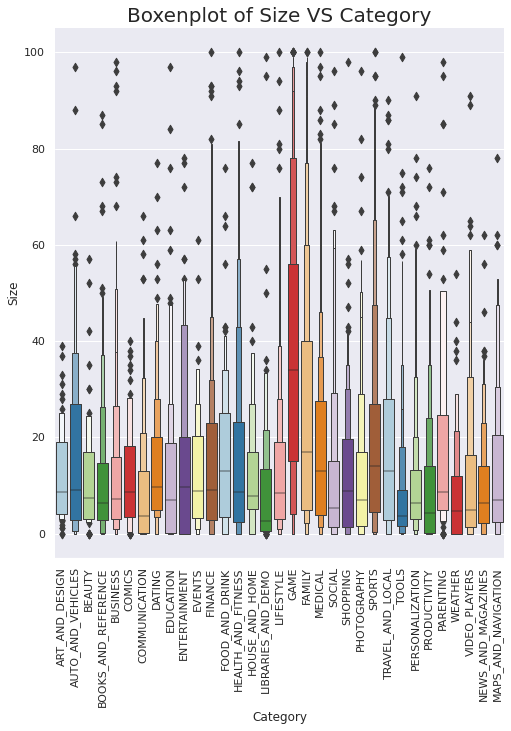

In [ ]:
g = sns.catplot(x="Category",y="Size",data=gps, kind="boxen", height = 8 ,palette = "Paired")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Size")
plt.title('Boxenplot of Size VS Category',size = 20)

### Price VS Category

Text(0.5, 1.0, 'Boxenplot of Price VS Category')

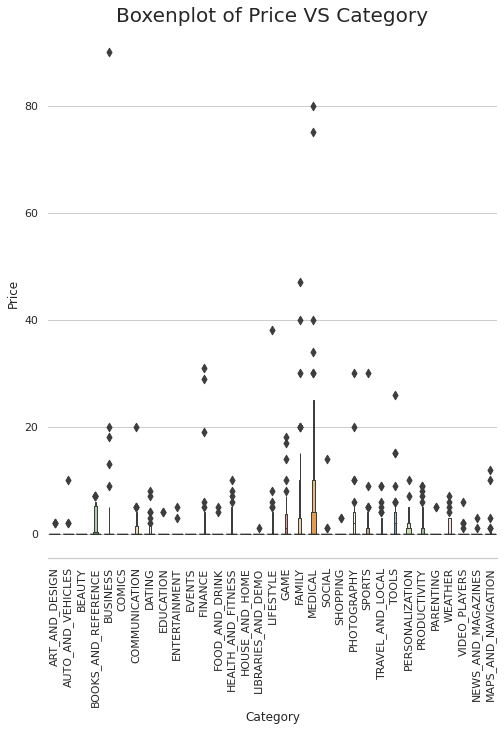

In [ ]:
g = sns.catplot(x="Category",y="Price",data=gps[gps['Price'] <100], kind="boxen", height = 8 ,palette = "Paired")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Price")
plt.title('Boxenplot of Price VS Category',size = 20)

### Overall value of apps in the dataset

*   number of installs X app price


### Category grouped by Fre/Paid Type

In [ ]:
categories_by_price = gps[['Category', 'Type']]

In [ ]:
categories_by_price['Type'].unique()

array(['Free', 'Paid'], dtype=object)

Category grouped by Reviews: chart

In [ ]:
#plot it
categories_by_price['Free']=(categories_by_price['Type']=='Free').astype(int)
categories_by_price['Paid']=(categories_by_price['Type']=='Paid').astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
categories_by_price = categories_by_price.groupby(['Category']).sum()
categories_by_price = categories_by_price.T

In [ ]:
categories_by_price.head()

Category,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,EVENTS,FAMILY,FINANCE,FOOD_AND_DRINK,GAME,HEALTH_AND_FITNESS,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,LIFESTYLE,MAPS_AND_NAVIGATION,MEDICAL,NEWS_AND_MAGAZINES,PARENTING,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER
Free,58,82,53,194,408,56,288,165,104,85,63,1693,328,110,860,273,73,83,350,126,312,252,58,295,262,346,200,236,301,750,207,160,71
Paid,3,3,0,28,12,0,27,6,2,2,1,185,17,2,82,15,0,1,19,5,83,2,2,81,19,28,2,3,24,78,12,4,8


In [ ]:
categories_by_price = categories_by_price.div(categories_by_price.sum())

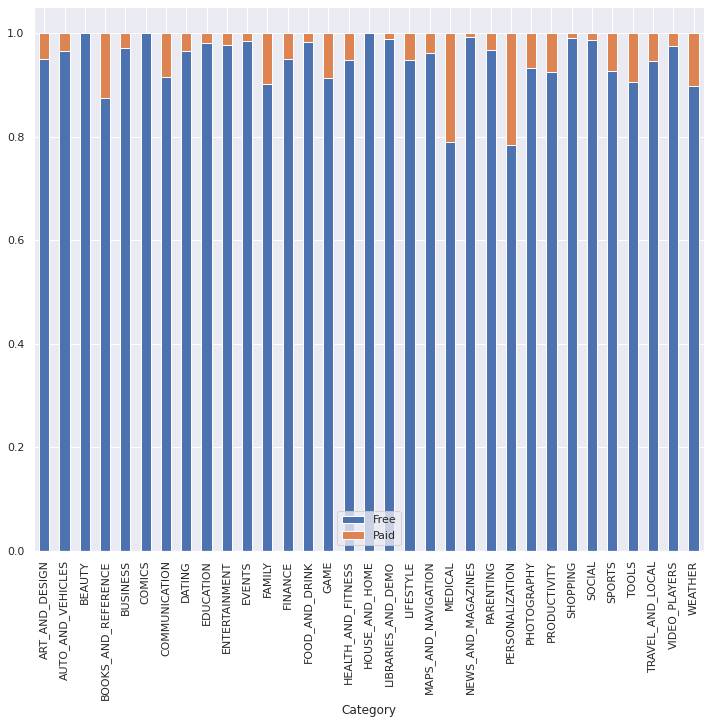

In [ ]:
sns.set()
sns.color_palette("pastel")
categories_by_price.T.plot(kind='bar', stacked=True)

In [ ]:
gps_app_install_rating = gps[['App', 'Installs', 'Rating', 'Price']]
gps_app_install_rating = gps_app_install_rating[gps_app_install_rating['Installs'] != 0]
gps_app_install_rating

,App,Installs,Rating,Price
0,Photo Editor & Candy Camera & Grid & ScrapBook,10000,4.1,0.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",5000000,4.7,0.0
3,Sketch - Draw & Paint,50000000,4.5,0.0
4,Pixel Draw - Number Art Coloring Book,100000,4.3,0.0
5,Paper flowers instructions,50000,4.4,0.0
...,...,...,...,...
10836,Sya9a Maroc - FR,5000,4.5,0.0
10837,Fr. Mike Schmitz Audio Teachings,100,5.0,0.0
10838,Parkinson Exercices FR,1000,NaN,0.0
10839,The SCP Foundation DB fr nn5n,1000,4.5,0.0


In [ ]:
gps_app_install_rating = gps_app_install_rating.sort_values(by=['Installs'], ascending=False)
gps_app_install_rating = gps_app_install_rating.groupby('Installs').mean().reset_index()
gps_app_install_rating.head()

,Installs,Rating,Price
0,1,5.000000,2.716418
1,5,4.611111,0.878049
2,10,4.624638,1.189610
3,50,4.419643,0.558824
4,100,4.363696,1.145070


### Number of Installation VS Price or Rating

In [ ]:
gps_app_install_rating = gps_app_install_rating.sort_values(by=['Installs'], ascending=False)
gps_app_install_rating['Installs'] = gps_app_install_rating['Installs'].astype(str)

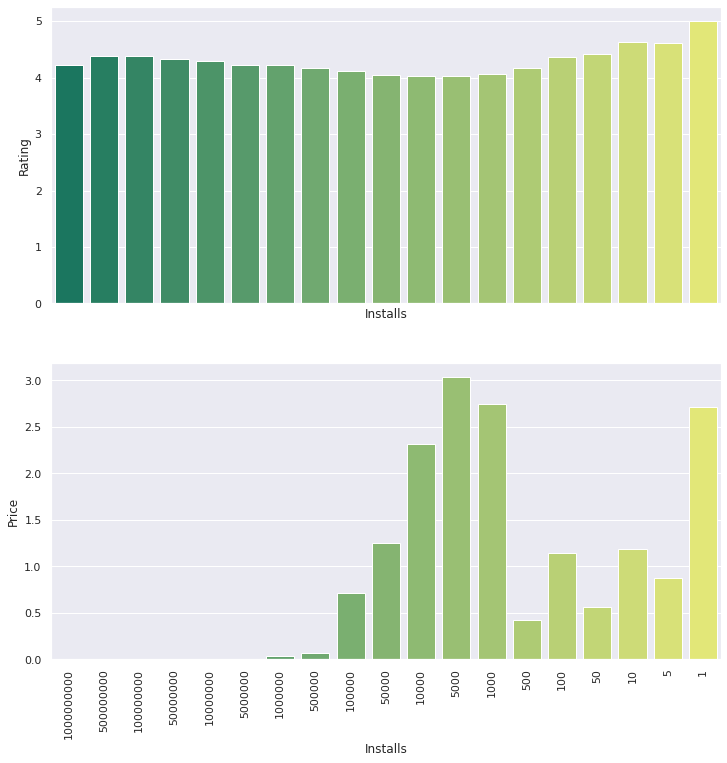

In [ ]:
#gps_app_install_rating = gps_app_install_rating.reset_index()

sns.set(style="darkgrid")

f, (ax1, ax2) = plt.subplots(
    2, sharex=True, figsize=(12,12))

sns.barplot(
    data=gps_app_install_rating,
    x='Installs',
    y='Rating',
    ax=ax1,
    palette='summer')

sns.barplot(
    data=gps_app_install_rating,
    x='Installs',
    y='Price',
    ax=ax2,
    palette='summer')

#ax1.set_yscale('log')
#ax2.set_yscale('log')
plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()

## Google Play Store Review

In [ ]:
gps_us_sentiment = gps_ur.copy()
gps_us_sentiment.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [ ]:
gps_us_sentiment['Positive Sentiment']=(gps_us_sentiment['Sentiment']=='Positive').astype(int)
gps_us_sentiment['Negative Sentiment']=(gps_us_sentiment['Sentiment']=='Negative').astype(int)
gps_us_sentiment['Neutral Sentiment']=(gps_us_sentiment['Sentiment']=='Neutral').astype(int)

gps_us_sentiment.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity,Positive Sentiment,Negative Sentiment,Neutral Sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333,1,0,0
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462,1,0,0
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000,1,0,0
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000,1,0,0
5,10 Best Foods for You,Best way,Positive,1.00,0.300000,1,0,0


In [ ]:
gps_us_sentiment = gps_us_sentiment.groupby(['App']).agg({'Sentiment_Polarity': 'mean', 'Sentiment_Subjectivity': 'mean', 'Positive Sentiment': 'sum', 'Negative Sentiment': 'sum', 'Neutral Sentiment': 'sum'}).reset_index()

In [ ]:
# join two dataframes on App column
gps_join = gps_us_sentiment.merge(gps[['App', 'Category', 'Rating', 'Reviews']], on='App', how='left')

In [ ]:
# some application names are not presented in the 1st dataframe
print(gps_join.isnull().values.any())

True


In [ ]:
gps_join = gps_join.dropna()
gps_join.head()

,App,Sentiment_Polarity,Sentiment_Subjectivity,Positive Sentiment,Negative Sentiment,Neutral Sentiment,Category,Rating,Reviews
0,10 Best Foods for You,0.470733,0.495455,162,10,22,HEALTH_AND_FITNESS,4.0,2490.0
2,11st,0.185943,0.455340,23,7,9,SHOPPING,3.8,48732.0
3,1800 Contacts - Lens Store,0.318145,0.591098,64,6,10,MEDICAL,4.7,23160.0
4,1LINE – One Line with One Touch,0.196290,0.557315,27,8,3,GAME,4.6,214878.0
5,2018Emoji Keyboard 😂 Emoticons Lite -sticker&gif,0.449566,0.520573,25,1,6,PERSONALIZATION,4.2,115773.0


### Sentiment By Category

In [ ]:
gps_sentiment_category = gps_join[['Category', 'Positive Sentiment', 'Negative Sentiment', 'Neutral Sentiment']]
gps_sentiment_category = gps_sentiment_category.groupby('Category').sum()

In [ ]:
gps_sentiment_category = gps_sentiment_category.T
gps_sentiment_category.head()

Category,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,EVENTS,FAMILY,FINANCE,FOOD_AND_DRINK,GAME,HEALTH_AND_FITNESS,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,LIFESTYLE,MAPS_AND_NAVIGATION,MEDICAL,NEWS_AND_MAGAZINES,PARENTING,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER
Positive Sentiment,233,236,185,448,655,39,641,1068,394,668,125,2206,911,462,3358,1754,315,238,593,129,967,619,185,702,781,990,587,404,938,876,1034,190,142
Negative Sentiment,47,17,65,95,169,1,207,361,64,270,16,880,320,92,2181,257,87,51,169,27,223,276,23,146,235,269,177,209,337,256,367,83,28
Neutral Sentiment,58,36,88,108,258,5,176,286,66,156,17,336,204,84,263,238,109,44,192,36,210,145,52,155,160,204,134,128,204,319,291,58,31


In [ ]:
gps_sentiment_category = gps_sentiment_category.div(gps_sentiment_category.sum())
gps_sentiment_category.head()

Category,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,EVENTS,FAMILY,FINANCE,FOOD_AND_DRINK,GAME,HEALTH_AND_FITNESS,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,LIFESTYLE,MAPS_AND_NAVIGATION,MEDICAL,NEWS_AND_MAGAZINES,PARENTING,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER
Positive Sentiment,0.689349,0.816609,0.547337,0.688172,0.605360,0.866667,0.625977,0.622741,0.751908,0.610603,0.791139,0.644652,0.634843,0.724138,0.578766,0.779902,0.616438,0.714715,0.621593,0.671875,0.690714,0.595192,0.711538,0.699900,0.664116,0.676692,0.653675,0.545209,0.634212,0.603722,0.611111,0.574018,0.706468
Negative Sentiment,0.139053,0.058824,0.192308,0.145929,0.156192,0.022222,0.202148,0.210496,0.122137,0.246801,0.101266,0.257160,0.222997,0.144201,0.375905,0.114273,0.170254,0.153153,0.177149,0.140625,0.159286,0.265385,0.088462,0.145563,0.199830,0.183869,0.197105,0.282051,0.227857,0.176430,0.216903,0.250755,0.139303
Neutral Sentiment,0.171598,0.124567,0.260355,0.165899,0.238447,0.111111,0.171875,0.166764,0.125954,0.142596,0.107595,0.098188,0.142160,0.131661,0.045329,0.105825,0.213307,0.132132,0.201258,0.187500,0.150000,0.139423,0.200000,0.154536,0.136054,0.139440,0.149220,0.172740,0.137931,0.219848,0.171986,0.175227,0.154229


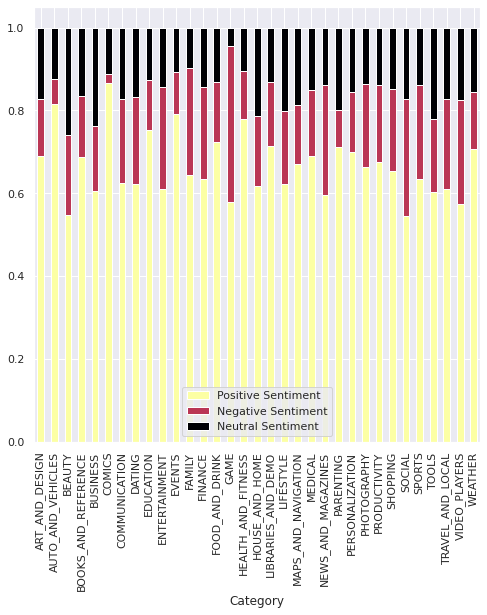

In [ ]:
gps_sentiment_category.T.plot(kind='bar', stacked=True, figsize=(8,8), colormap='inferno_r')

googleplaystore.csv **Correlation**

googleplaystore_user_review.csv **Correlation**